# Generalized Aliasing Decomposition (GAD) Experiments

Decompose $\mathbf{E}_\theta$ into Aliasing ${\textcolor{blue}{\mathbf{A}}} = \mathbf{M}_{\mathcal{TM}}^+ \mathbf{M}_{\mathcal{TU}}$, Model insufficiency $\textcolor{red}{\mathbf{I}_{\mathcal{U}}}$ and Data insufficiency $\textcolor{green}{\mathbf{P}_{\mathcal{N}}} = \mathbb{I}_{\mathcal{M}} - \mathbf{M}^+_{\mathcal{TM}}\mathbf{M}_{\mathcal{TM}}$.


For a variety of datasets, plot those three components (and/or ${\textcolor{blue}{\mathbf{A}}} \theta$, $\textcolor{red}{\mathbf{I}_{\mathcal{U}}}\theta$, and $\textcolor{green}{\mathbf{P}_{\mathcal{N}}}\theta$) as functions of the number of model parameters.




## Using GAD on the models of Belkin and Mei-Montanari


Belkin and Mei-Montanari apply the following to data sets (MNIST and CIFAR-10 and MM sphere):

* Convert color to grayscale for CIFAR
* Normalize features to $[0,1]$ for MNIST and CIFAR (MM sphere is already normalized to radius $\sqrt{d}$).
* $d$ total features ($d = 28^2$ for MNIST and $d = 1024$ for CIFAR and MM sphere)
* Belkin [appendix S2, Table S1] says "In experiments we use subsets to reduce the computational cost"
* Labels are one-hot encoded with rows $Y_{i,:} = \mathbf{y}_{i} = (y_{i,0}, \dots, y_{i,9})$, with $Y$ of shape $N\times 10$.  Belkin says they use one-vs-rest, so we assume they are taking just one of the columns of $Y$ as the labels.


For each data set (of total size $N$) and set of basis functions do the following:
* Choose D>>N total basis functions (modeled and unmodeled).   The universe matrix 
$$\mathbb{M} = 
\begin{bmatrix}
\mathbf{M}_{\mathcal{TM}} & \mathbf{M}_{\mathcal{TU}}\\
\mathbf{M}_{\mathcal{PM}} & \mathbf{M}_{\mathcal{PU}}
\end{bmatrix}
$$
of shape $N\times D$ consists of $D$ columns, corresponding to these basis functions (modeled on the left, and unmodeled on the right) evaluated at all $N$ data points.  The rows correspond to individual data points, with training points at the top and test/prediction points at the bottom. Thus $\mathbf{M}_{\mathcal{TM}}$ is the block corresponding to training points and modeled basis functions, $\mathbf{M}_{\mathcal{TU}}$ is the block corresponding to training points and unmodeled basis functions, $\mathbf{M}_{\mathcal{PM}}$ is the block corresponding to prediction points and modeled basis functions, and $\mathbf{M}_{\mathcal{PU}}$ is the block corresponding to prediction points and unmodeled basis functions.

Choose $D$ large enough that the model can fit the data well enough, that is, the approximate labels $\hat{Y} =  (\mathbb{M}^+ Y)$ should be close enough to the true labels that we can assume the true parameters are $\mathbf{\theta} = \mathbb{M}^+ Y$ (or a mildly regularized version).  $\mathbf{\theta}$ should have shape $D\times 1$

* For each choice of model size $m$ (corresponding to a decomposition of the chosen function space $\mathcal{D}$ into $\mathcal{D} = \mathcal{M} \oplus \mathcal{U}$ with $\mathcal{M}$ being the modeled subspace and $\mathcal{U}$ being the unmodeled subspace), do the following:
    + Compute $\|\mathbf{\theta}_{\mathcal{U}}\| = \|\textcolor{red}{\mathbf{I}_{\mathcal{U}}}\theta_{\mathcal{U}}\|$ full unmodeled thetas (model insufficiency)
    + Compute $\|\mathbf{\theta}_{\mathcal{M}}\|$ full modeled thetas
    + Compute $\|{\textcolor{blue}{\mathbf{A}}}\| = \|\mathbf{M}_{\mathcal{TM}}^+ \mathbf{M}_{\mathcal{TU}}\|$ AND $\|{\textcolor{blue}{\mathbf{A}}}\mathbf{\theta}_{\mathcal{M}}\|$
    + Compute Data insufficiency $\|\textcolor{green}{\mathbf{P}_{\mathcal{N}}} \theta_{\mathcal{M}}\| = \|(\mathbb{I}_{\mathcal{M}} - \mathbf{M}^+_{\mathcal{TM}}\mathbf{M}_{\mathcal{TM}})\theta_{\mathcal{M}}\|$
    + Compute $\|\hat{\theta}_{\mathcal{TM}}\|^2 = \|\mathbf{M}_{\mathcal{TM}}^+ Y_{\mathcal{T}}\|^2$
    







Random Feature models are coordinate-wise equal to 
$$ 
h(\mathbf{x}) = \sum_k \theta_k \varphi(\langle \mathbf{v}_k , \mathbf{x}\rangle),
$$
where 
* RFF has $\varphi(z) = \exp(i z)$ and $\mathbf{v}_k$ drawn from $\text{MVN}(0,\frac{1}{25} \mathbf{I}_d)$ (scale is $1/5$)
* RRF has $\varphi(z) = \max(z,0)$ and $\mathbf{v}_k$ drawn from $\text{Unif}(S^{d-1})$



### Setup and helper code

In [1]:
## Using Python 3.13.3
!pip install numpy pandas matplotlib torch torchvision scipy

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import pinv, norm, lstsq
from scipy.linalg import svd

rng = np.random.default_rng(seed=19876554678687654345678)
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#import pandas as pd
from warnings import warn

plt.rcParams["savefig.bbox"] = 'tight'

In [3]:
# Define some functions needed in the experiments

def random_weights(r,c,kind='MVN', scale_factor=1):
    """Generate random weights of shape r x c, either Gaussian (MVN) or 
    uniform from the sphere of radius = scale_factor.
    
    """

    W = rng.standard_normal((r,c)) * scale_factor # Gaussian with stDev=scale_factor

    if kind == 'sphere' or kind == 'uniform':
        W = scale_factor * W/norm(W, axis=0).reshape(1,-1) # scale to sphere of radius=scale_factor
        # MVN is spherically symmetric, so rescaling makes it the same as uniform on the sphere
    return W

def relu(x):
    # ReLU activation
    return np.maximum(x,0)

def ff(x):
    # Fourier feature activation
    return np.exp(1j*x)


In [4]:
# Code to define the Universe matrix
def universe(X, activation=relu, scale_factor=1):
    
    """
    Produce the full Universe matrix with given activation for data set (inputs) X,
    partitioned with t training points and $D$ total basis functions.
    
    Parameters
    ----------
    X : numpy array
        Data matrix of shape N x d

    activation : function, optional
        Activation function, by default relu

    scale_factor : float, optional
        Scale factor for the random weights, by default 1

    Returns
    -------
    M : numpy array
        Vandermonde-like universe matrix of shape N x D
    
    """

    N = X.shape[0] # number points in the "data universe"

    D = (3 * N) // 2 + 1 # Total number of "possible" basis functions
    
    # Initialize Universe matrix
    if activation == ff:
        M = np.empty((N,D), dtype=np.complex128)
    else:
        M = np.empty((N,D), dtype=np.float64)
    
    # First column is all ones -- the constant function
    M[:,0] = 1

    # Random weights
    if activation == ff:
        kind = 'sphere'
    else:
        kind = 'MVN'

    if scale_factor is None:
        if activation == ff:
            scale_factor = 0.2 # 1/5    
        else:
            scale_factor = 1

    V = random_weights(X.shape[1], D - 1, kind=kind, scale_factor=scale_factor)        
    
    # Compute the rest of the Universe matrix
    M[:,1:] = activation(X @ V)

    return M


In [5]:
def parameter_setup(M, Y, t, regularization=1e-5):
    """
    Compute the parameters theta of the linear model Y = M theta and adjust Y to make
    these computed thetas be "true."
    
    Parameters
    ----------
    M : numpy array
        Universe matrix of shape N x D
    Y : numpy array
        Target (labels) of shape N
    t : int
        Number of training points (interpolation threshold)
    regularization : float, optional
        Regularization parameter, by default 1e-5.  Regularization penalty is 
        exponential in the index of the basis function (or rather in the index 
        past the interpolation threshold t).

    Returns
    -------
    theta : numpy array
        Parameters of the linear model of shape D
    Y : numpy array
        Adjusted target of shape N
    """

    def penalty(x):
        return np.exp(x) 
    
    N,D = M.shape

    R = N * regularization * np.diag(penalty((np.arange(D) - t)/t)) # regularization matrix

    Ureg = np.vstack([M,R]) # Augmented universe matrix
    Yreg = np.concatenate([Y, np.zeros(D)]) # Augmented target vector

    theta = lstsq(Ureg, Yreg, rcond=None)[0] # solve for "true" parameters
    Yhat = M @ theta    # predicted labels.  These will replace the original labels Y

    total_risk = norm(Yhat - Y, ord=2)
    # print(f"Failure to fit = {total_risk}")
    
    # "Correct" the labels to be perfectly consistent with the new "true" parameter values
    # so tha the completeness assumption holds
    Y = Yhat

    return theta, Y

In [6]:
# Code to compute all the various norms

def all_norms(M, Y, theta, t, ms=None): 
    """For a given universe M, labels Y, true parameters theta, training set t, 
    and model sizes in ms, compute the norms of the following (all are 2-norms unless otherwise specified):
    - A = M^+ U the aliasing matrix and A theta_U
    - P = (I - M^+ M) the data insufficiency (use Frobenius norm, since the 2-norm is always 1 or 0)
    - P theta_M = (I - M^+ M)theta_M the data insufficiency parameter error 
    - IU theta = theta_U the model insufficiency parameter error
    - true risk = ||Y - MTM theta_hat||_2^2 = ||M E_theta theta||_2^2

    Parameters
    ----------
    M : numpy array
        Universe matrix of shape N x D
    Y : numpy array
        Labels of shape N
    t : int
        Number of training points.  Should be less than N.
    ms : list of ints, optional
        Model sizes, by default None. If None, use a default list of model sizes.

    Returns
    ------- 
    ms : numpy array
        Model sizes
    ||A|| : numpy array of shape len(ms)
        Norm of aliasing matrix for each model size
    ||A theta|| : numpy array of shape len(ms)
        Norm of aliased parameters for each model size
    ||P theta_M|| : numpy array of shape len(ms)
        Norm of data insufficiency parameter error for each model size
    ||IU theta|| = ||theta_U|| : numpy array of shape len(ms)
        Norm of model insufficiency for each model size
    true risk : numpy array of shape len(ms)
        true risks for each model size
    
    """

    N,D = M.shape
    assert t < N, "Number of training points should be less than total number of points"

    if ms is None: 
        try:
            ms = list(range(2,t,t//30)) + list(range(t, 2*t, t//11)) + list(range(2*t, D, t)) 
        except ValueError:
            warn(f"Could not generate default model sizes for D={D}, t={t}. Using ms = range(2,D,t) instead")
            ms = list(range(2,D,t))
        ms = ms[:-2] # remove the last two model sizes to avoid numerical issues at the end.
        


    # Initialize arrays to be all nans
    A_norm = np.empty(len(ms)); A_norm[:] = np.nan
    A_theta_norm = np.empty(len(ms)); A_theta_norm[:] = np.nan
    P_theta_norm = np.empty(len(ms)); P_theta_norm[:] = np.nan
    IU_theta_norm = np.empty(len(ms)); IU_theta_norm[:] = np.nan
    label_risk = np.empty(len(ms)); label_risk[:] = np.nan

    for i,m in enumerate(ms):
        print(f'm = {m}, out of {ms[-1]}', end='\r') # running report of model size

        # Modeled and train matrix
        MTM = M[:t, :m]
        # Modeled and prediction matrix
        MPM = M[t:, :m]

        # Pseudo-inverse of MTM
        try: # SVD does not always converge
            MTMinv = pinv(MTM)
        except:
            warn(f"SVD did not converge for model size m={m}")
            continue
        
        # Unmodeled and train matrix
        MTU = M[:t, m:]

        # Aliasing matrix
        A = MTMinv @ MTU

        # Data insufficiency matrix
        P = np.eye(m) - MTMinv @ MTM

        # Modeled (true) paramters
        theta_M = theta[:m]
        # Unmodeled (true) parameters
        theta_U = theta[m:]

        # Estimated parameters for this model
        theta_hat = MTMinv @ Y[:t]
        # Estimated labels for the training points
        Y_hat_t = MTM @ theta_hat
        # Estimated labels for the validation points
        Y_hat_v = MPM @ theta_hat

        # Norm of Aliasing
        A_norm[i] = norm(A, ord=2)
        atu = A @ theta_U # need this later for param_risk
        A_theta_norm[i] = norm(atu, ord=2)

        # Norm of Data Insufficiency (operator always has 2-norm 1 or 0)
        ptm = P @ theta_M # data insufficiency parameter error
        P_theta_norm[i] = norm(ptm, ord=2)

        # Norm of Model Insufficiency (operator always has 2-norm 1)
        IU_theta_norm[i] = norm(theta_U, ord=2)

        label_risk[i] = np.sqrt(norm(Y_hat_t - Y[:t], ord=2)**2 + norm(Y_hat_v - Y[t:], ord=2)**2)

    return ms, [A_norm, A_theta_norm, P_theta_norm, IU_theta_norm, label_risk]



In [7]:
# Code to plot the results
def plot_results(ms, t, D, results, title=None, y_min=None, y_max=None, figsize=(7,3)):
    """Plot the results of the norms computed by all_norms
    
    Parameters
    ----------
    ms : numpy array
        Model sizes
    t : int
        Number of training points.  
    D : int 
        Total number of basis functions in the Universe matrix
    results : list    
        List of norms should contain, in order,
        A_norm, A_theta_norm, P_theta_norm, IU_theta_norm, label_risk
        each of which should have a shape of len(ms)
    title : str, optional
        Title of the plot, by default None
    y_min : float, optional  
        Minimum value of the y-axis.  Will default to min of
        the data (except for data insuff P_theta, which has min = 0)
    y_max : float, optional  
        Maximum value of the y-axis.  Will default to max of
        the data.
    figsize : tuple, optional
        Size of the figure, by default (7,3)
    """

    red = (196/255, 0, 0)
    green = (0, 96/255, 0)
    blue = (0, 0, 196/255)

    colors = [blue, blue, green, red, 'k']
    line_types = ['--', '-', '-', '-', '-']
    labels = [r'$\|\mathbf{A}\|$ Aliasing operator', 
            r'$\|\mathbf{A}\theta_U\|_2$ Aliased param err', 
            r'$\|\mathbf{P}\theta_M\|_2$ Data insuff param err', 
            r'$\|\theta_U\|_2$ Model insuff param err',
            'Risk']

    plt.figure(figsize=figsize,dpi=300)
    for i, result in enumerate(results):
        plt.semilogy(ms, result, 
                 line_types[i], color=colors[i], 
                 lw=2, label=labels[i]) 

    # setup the x axis
    xs = range(0, D, t)
    plt.xticks(xs,[str(x//(t//10)) for x in xs])

    # setup the y axis, but omit P_theta because its log is -inf at the beginning
    all_values = np.concatenate([result[:-2] for result in results[:2]+results[3:]])
    all_values = all_values[~np.isnan(all_values)]

    if y_min is None:
        y_min = np.min(all_values)
    if y_max is None:
        y_max = np.max(all_values)
    
    plt.ylim(y_min, y_max)

    # Label the x-axis
    if t == 10**4:
        plt.xlabel(r'Number of parameters $\times 10^3$')
    elif t == 10**3:
        plt.xlabel(r'Number of parameters $\times 10^2$')
    else:
        plt.xlabel(r'Number of parameters $\times$' + str(t//10))
   
    # Label the y-axis
    plt.ylabel(r'norm');
   
    # Title of the plot
    #plt.title(f"{kind} on {data}")

    plt.vlines(t, plt.ylim()[0], plt.ylim()[1], color='k',lw=1, linestyles='dashed')
    plt.legend(labelcolor='linecolor', frameon=False)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(f"title_results_{t}_{D}.pdf", bbox_inches='tight', dpi=300)
    plt.show()

### MNIST

In [ ]:
# Load MNIST data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
X = mnist_trainset.data.numpy().reshape(-1, 28*28)
X = X/255   # rescale to [0,1] to match Belkin.
Y = mnist_trainset.targets.numpy()

# one-vs-rest for digit 0, with a blanced number of points for each class
index_0 = np.argwhere(Y==0)
index_not0 = np.argwhere(Y!=0)[:len(index_0)] # random sample of same number of  points not 0
all_indices = np.sort(np.concatenate([index_0, index_not0]))

X = X[all_indices].reshape(-1, 28*28)
Y = Y[all_indices].reshape(-1)

N = X.shape[0]
D = N


#### MNIST RRF One-hot One-vs-Rest

In [ ]:
# Compute everything for MNIST  RRF with Y (One-vs-rest for digit 0)
## RRF 


# Prep the labels:  one-vs rest for digit 0
Y = (Y==0).astype(float)

t = 10**3 # number of training points (Belkin uses 10**4)

M = universe(X, activation=relu)

# This takes a little time, since the regularization means solving with a tweaked universe matrix that is much larger.
theta, Y = parameter_setup(M, Y, t,regularization=1e-5)
#plt.semilogy(np.abs(theta))

In [ ]:
# Compute all the norms for RRF MNIST with one-v-rest for digit 0 (Y)


D = N
ms, norms = all_norms(M[:,:D], Y, theta[:D], t, ms=None)

np.savez('rrf_mnist_GAD', t=t, D=D, ms=ms, norms=norms)

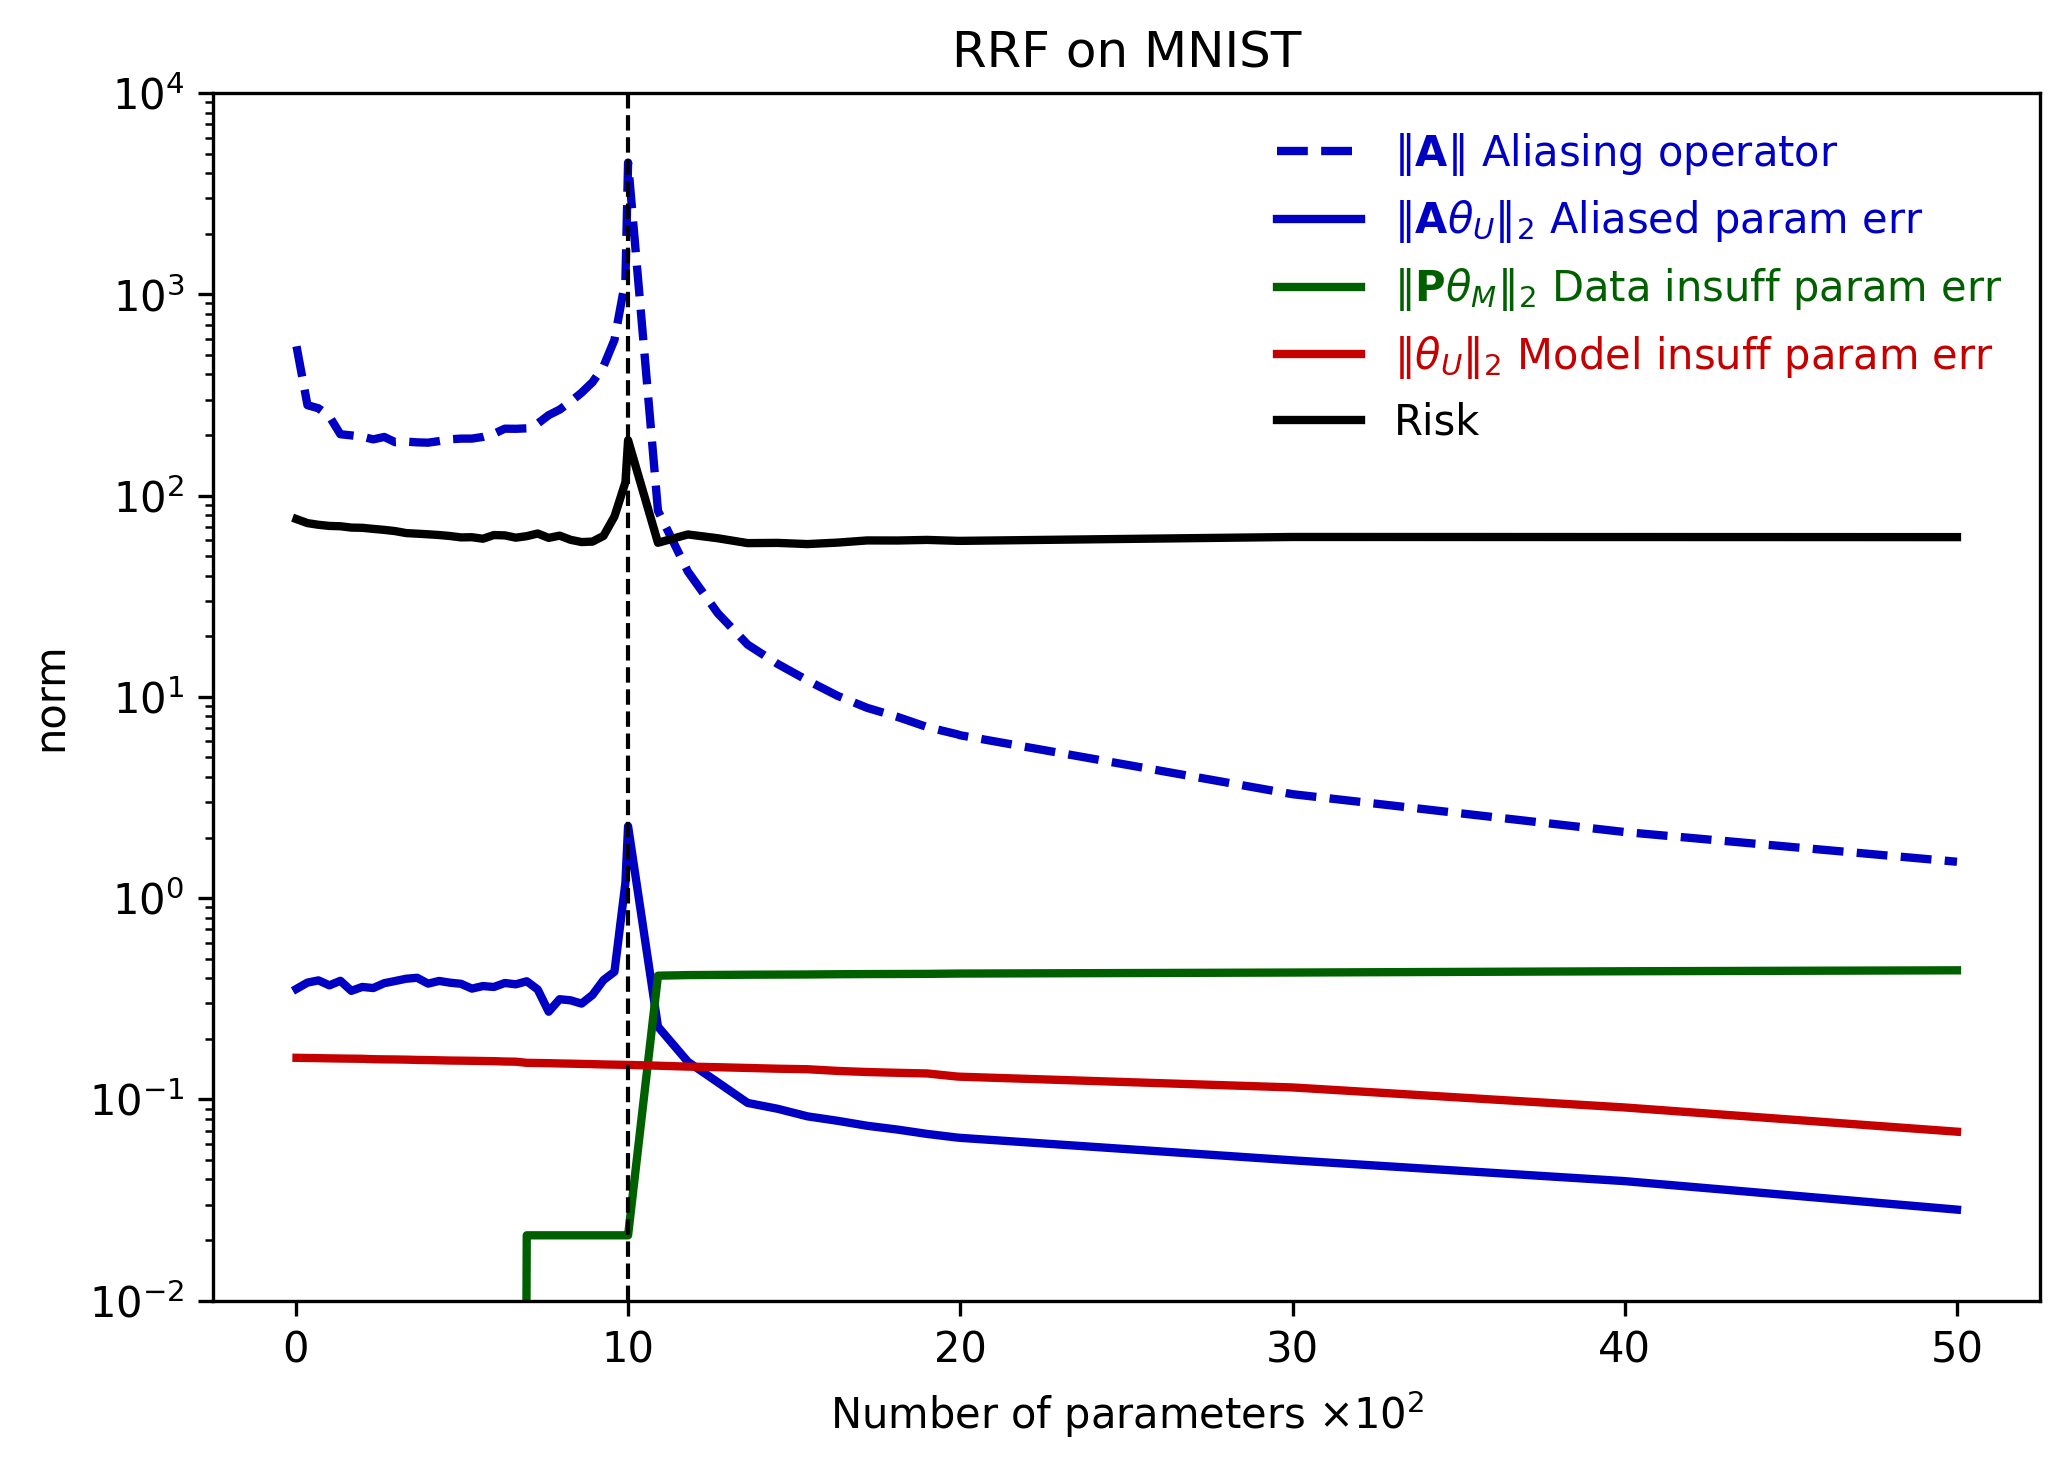

In [16]:
# load the results
data = np.load('rrf_mnist_GAD.npz')

t = data['t']
D = data['D']
ms = data['ms']
results = data['norms']
     
# Plot the results
plot_results(ms, t, D, results, title="RRF on MNIST", y_max=1e4, y_min=1e-2, figsize=(7,5))

#### MNIST RFF Logit link

In [ ]:
## Now use the logit as a link function to convert the labels to something that is maybe 
## more suitable for regression

# Recall that we tweaked the Y to match the completeness assumption.  We want to start here 
# with the original Y, which is 0-1, and then convert it to logit space.
Y = mnist_trainset.targets.numpy()
Y = Y[all_indices].reshape(-1)


epsilon = 0.0001
# 1 -> 1-ε,  and 0 -> ε

Z = (Y * (1 - 2* epsilon)) + epsilon # scale to (epsilon, 1-epsilon) to avoid log(0) and log(1) issues
Z = np.log(Z/(1-Z))                  # logit link function


# This takes a little time, since the regularization means solving with a tweaked universe matrix that is much larger.
theta, Z = parameter_setup(M, Z, t,regularization=1e-5)



In [14]:
# Compute everything for MNIST  RRF with Z  (logit link function for one-vs-rest for digit 0)
# This takes a while.

ms, norms = all_norms(M[:,:D], Z, theta[:D], t, ms=None)
np.savez('rrf_mnist_GAD_logit_link', t=t, D=D, ms=ms, norms=norms)

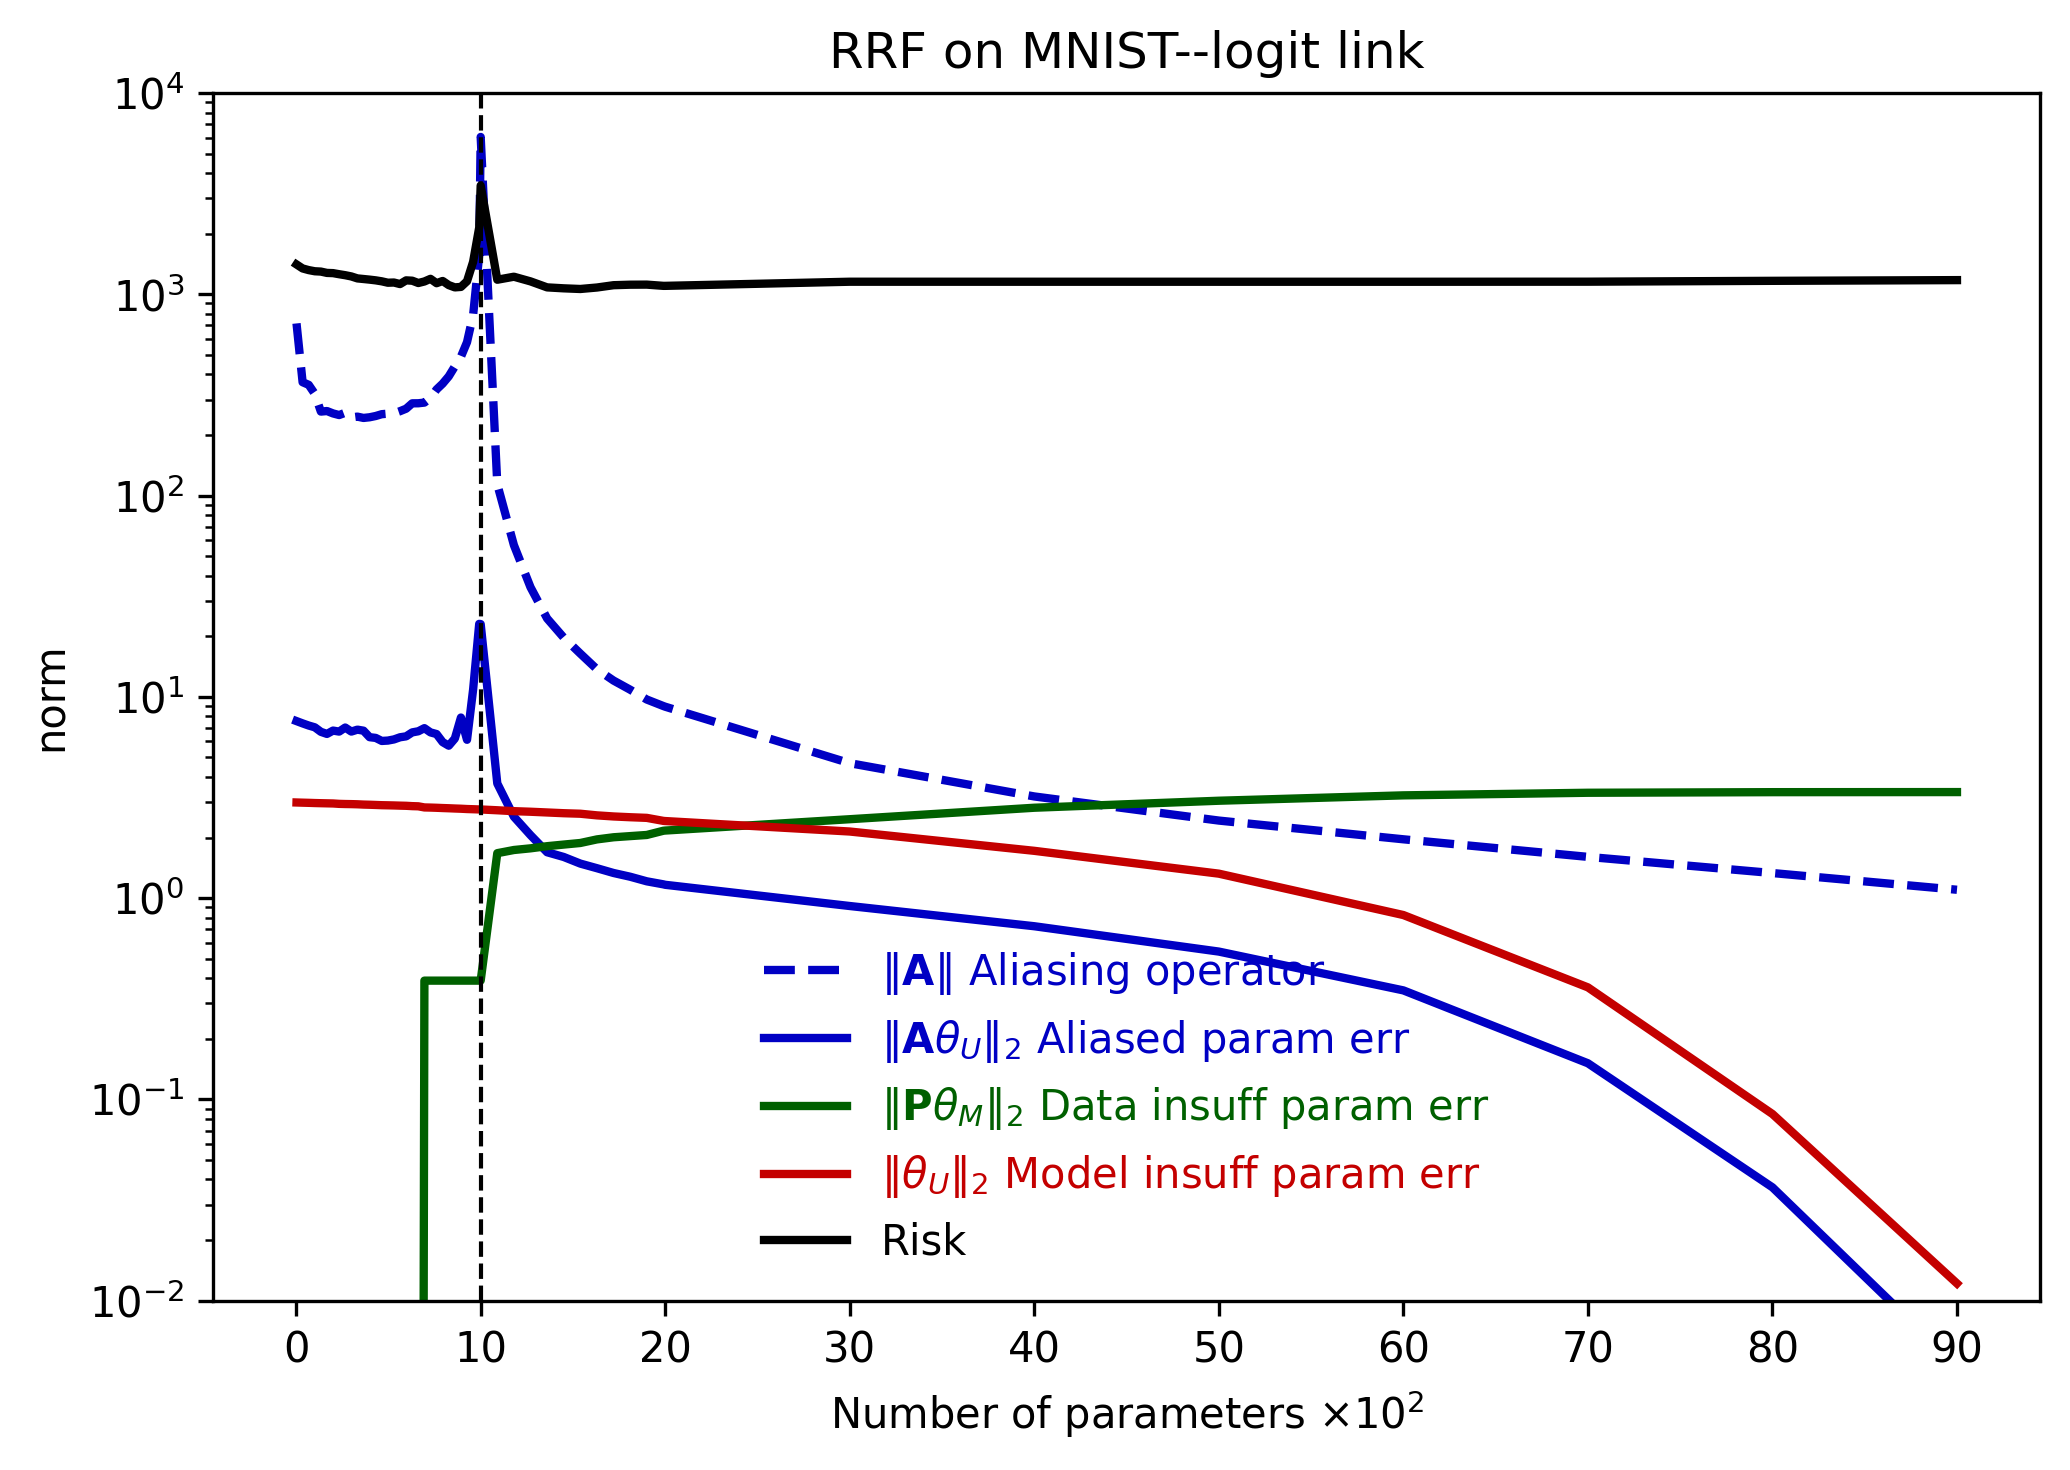

In [15]:
# load the results
data = np.load('rrf_mnist_GAD_logit_link.npz')

t = data['t']
D = data['D']
ms = data['ms']
results = data['norms']
     
plot_results(ms, t, D, results, title="RRF on MNIST--logit link", y_max=1e4, y_min=1e-2, figsize=(7,5))
## Remember that the risk is \|logit(Y) - M hat{\theta}\|_2^2, so it is not directly comparable to the risk 
## in the other plot, which is \|Y - M hat{\theta}\|_2^2



In [17]:
# Compute everything for MNIST  RFF
## RFF
## Y = one-vs-rest for digit 0

t = 10**3 # number of training points (Belkin uses 10**4)

M = universe(X, activation=ff, scale_factor=0.2)
theta, Y = parameter_setup(M, Y,t)  # takes some time because the regularization means 
                                    # solving with a tweaked universe matrix that is much larger.

In [18]:
## Compute all the norms for RFF MNIST with one-v-rest for digit 0 (Y)
D = min(t * 7 + 1, M.shape[1]) 
ms, norms = all_norms(M[:,:D], Y, theta[:D], t, ms=None)

np.savez('rff_mnist_GAD', t=t, D=D, ms=ms,  norms=norms)

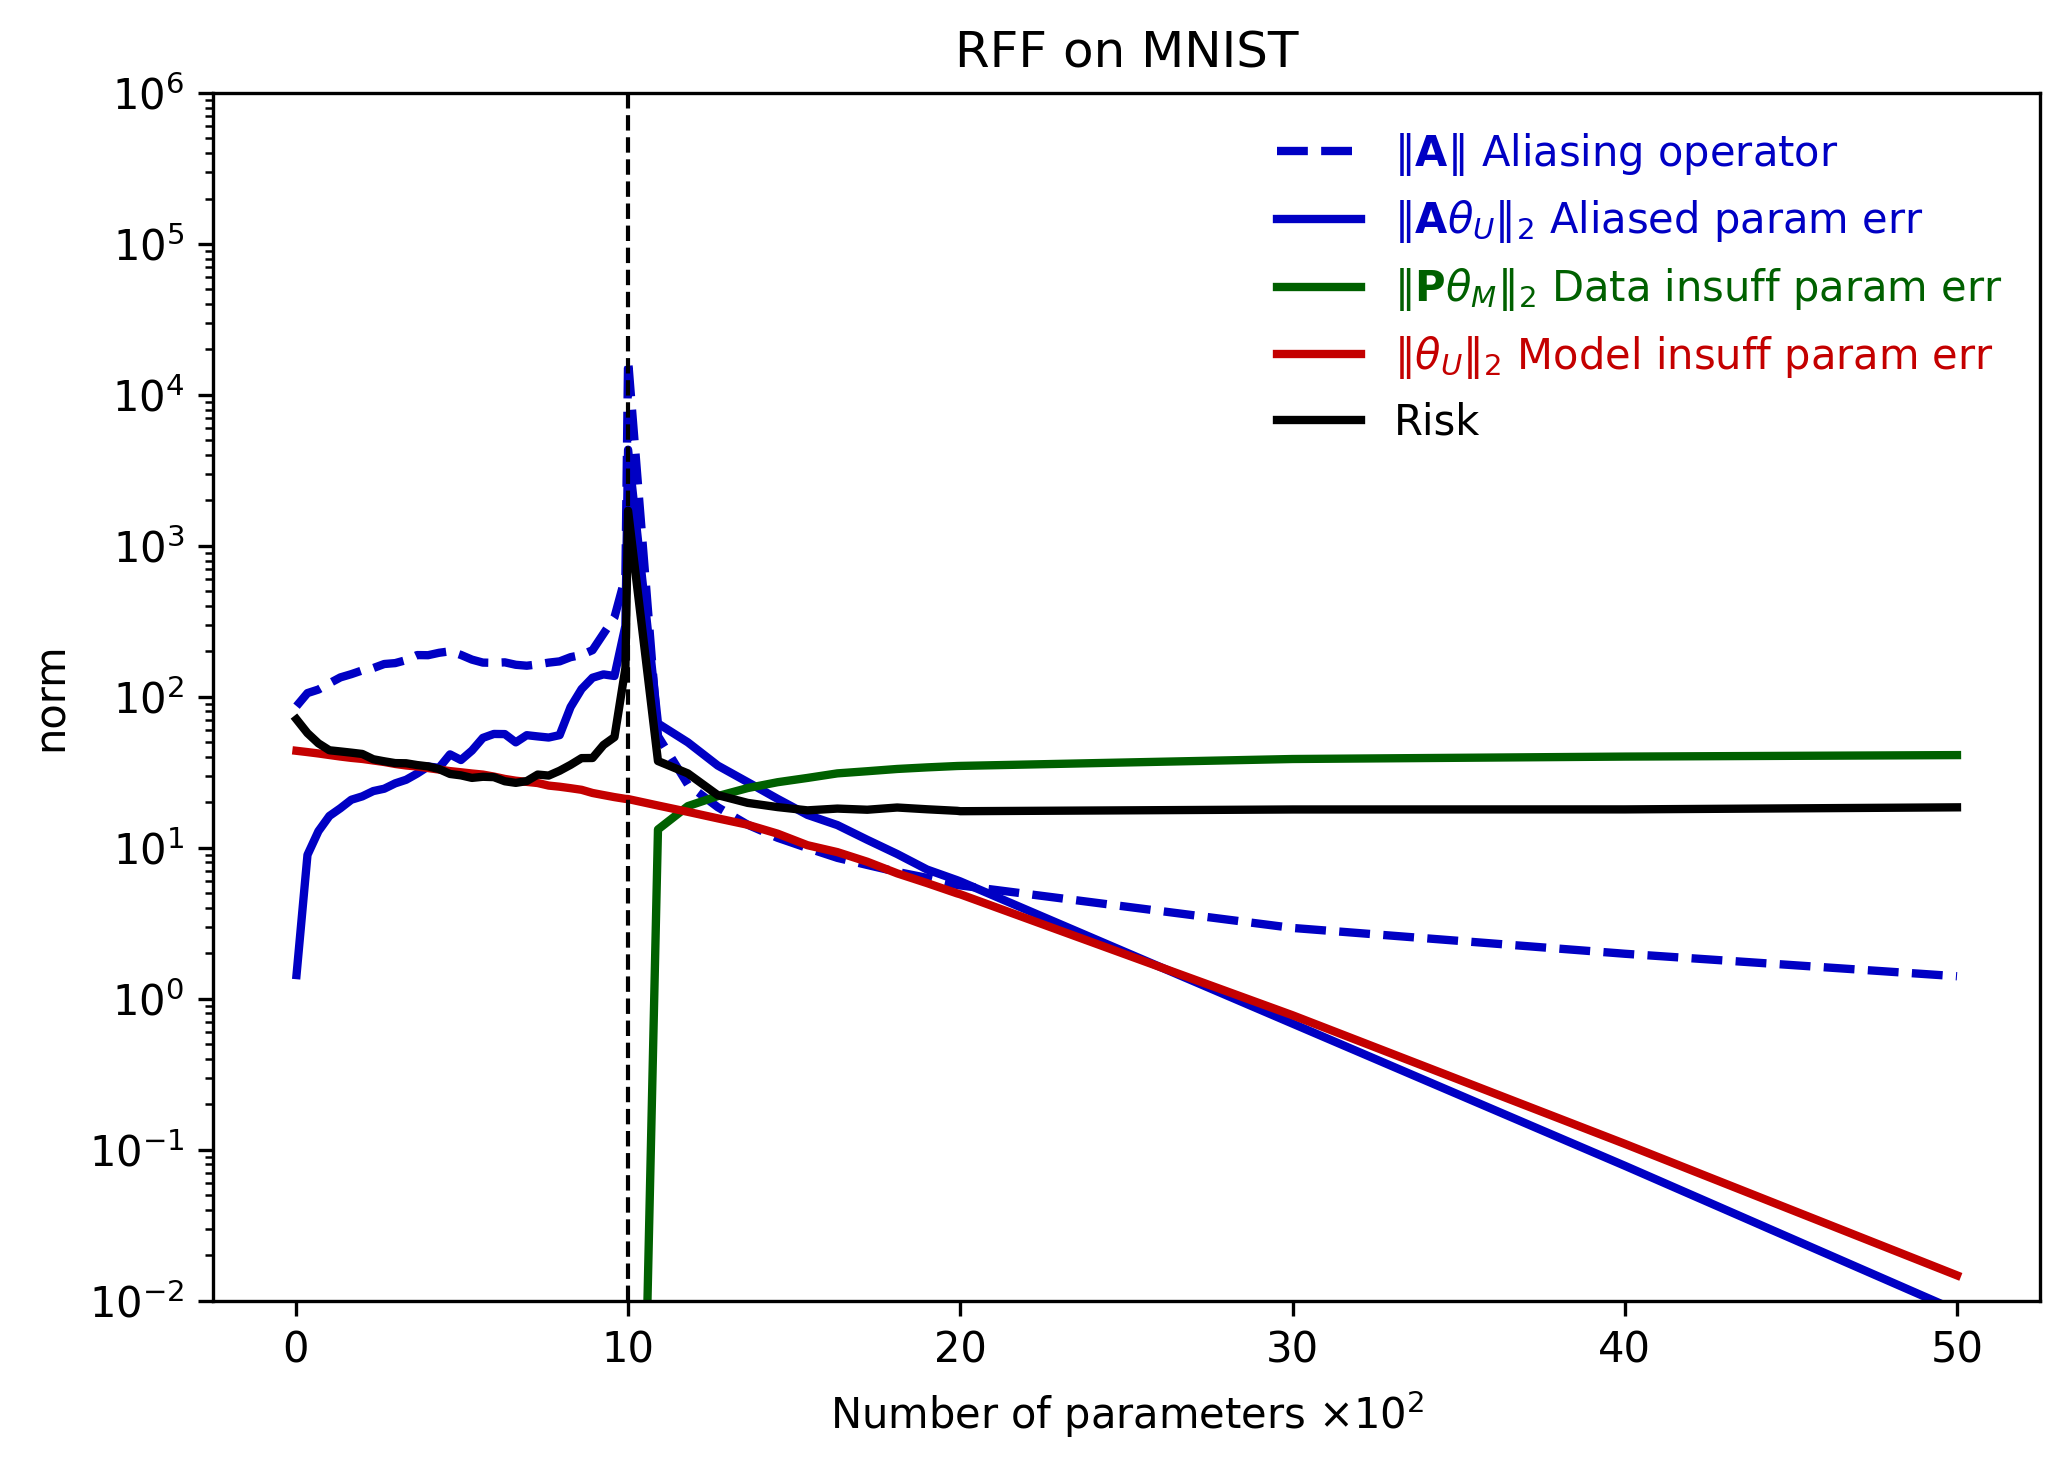

In [19]:
# Plot RFF MNIST

## load the results
data = np.load('rff_mnist_GAD.npz')
t = data['t']
D = data['D']
ms = data['ms']
norms = data['norms']

## Plot     
plot_results(ms, t, D, norms, title="RFF on MNIST",y_max=1e6,y_min=1e-2, figsize=(7,5))

In [20]:
## Now use the logit as a link function to convert the labels to something that is maybe 
## more suitable for regression

# Recall that we tweaked the Y to match the completeness assumption.  We want to start here 
# with the original Y, which is 0-1, and then convert it to logit space.
Y = mnist_trainset.targets.numpy()
Y = Y[all_indices].reshape(-1)


epsilon = 0.0001
# 1 -> 1-ε,  and 0 -> ε

Z = (Y * (1 - 2* epsilon)) + epsilon # scale to (epsilon, 1-epsilon) to avoid log(0) and log(1) issues
Z = np.log(Z/(1-Z))                  # logit link function


# Can use the same universe matrix M as the previous.
# This takes a little time, since the regularization means solving with a tweaked universe matrix that is much larger.
theta, Z = parameter_setup(M, Z, t,regularization=1e-5)



/tmp/ipykernel_157752/934909202.py:14: RuntimeWarning: invalid value encountered in log
  Z = np.log(Z/(1-Z))                  # logit link function


In [21]:
# Compute everything for MNIST  RFF with Z  (logit link function for one-vs-rest for digit 0)
# This takes a while.

ms, norms = all_norms(M[:,:D], Z, theta[:D], t, ms=None)
np.savez('rff_mnist_GAD_logit_link', t=t, D=D, ms=ms, norms=norms)

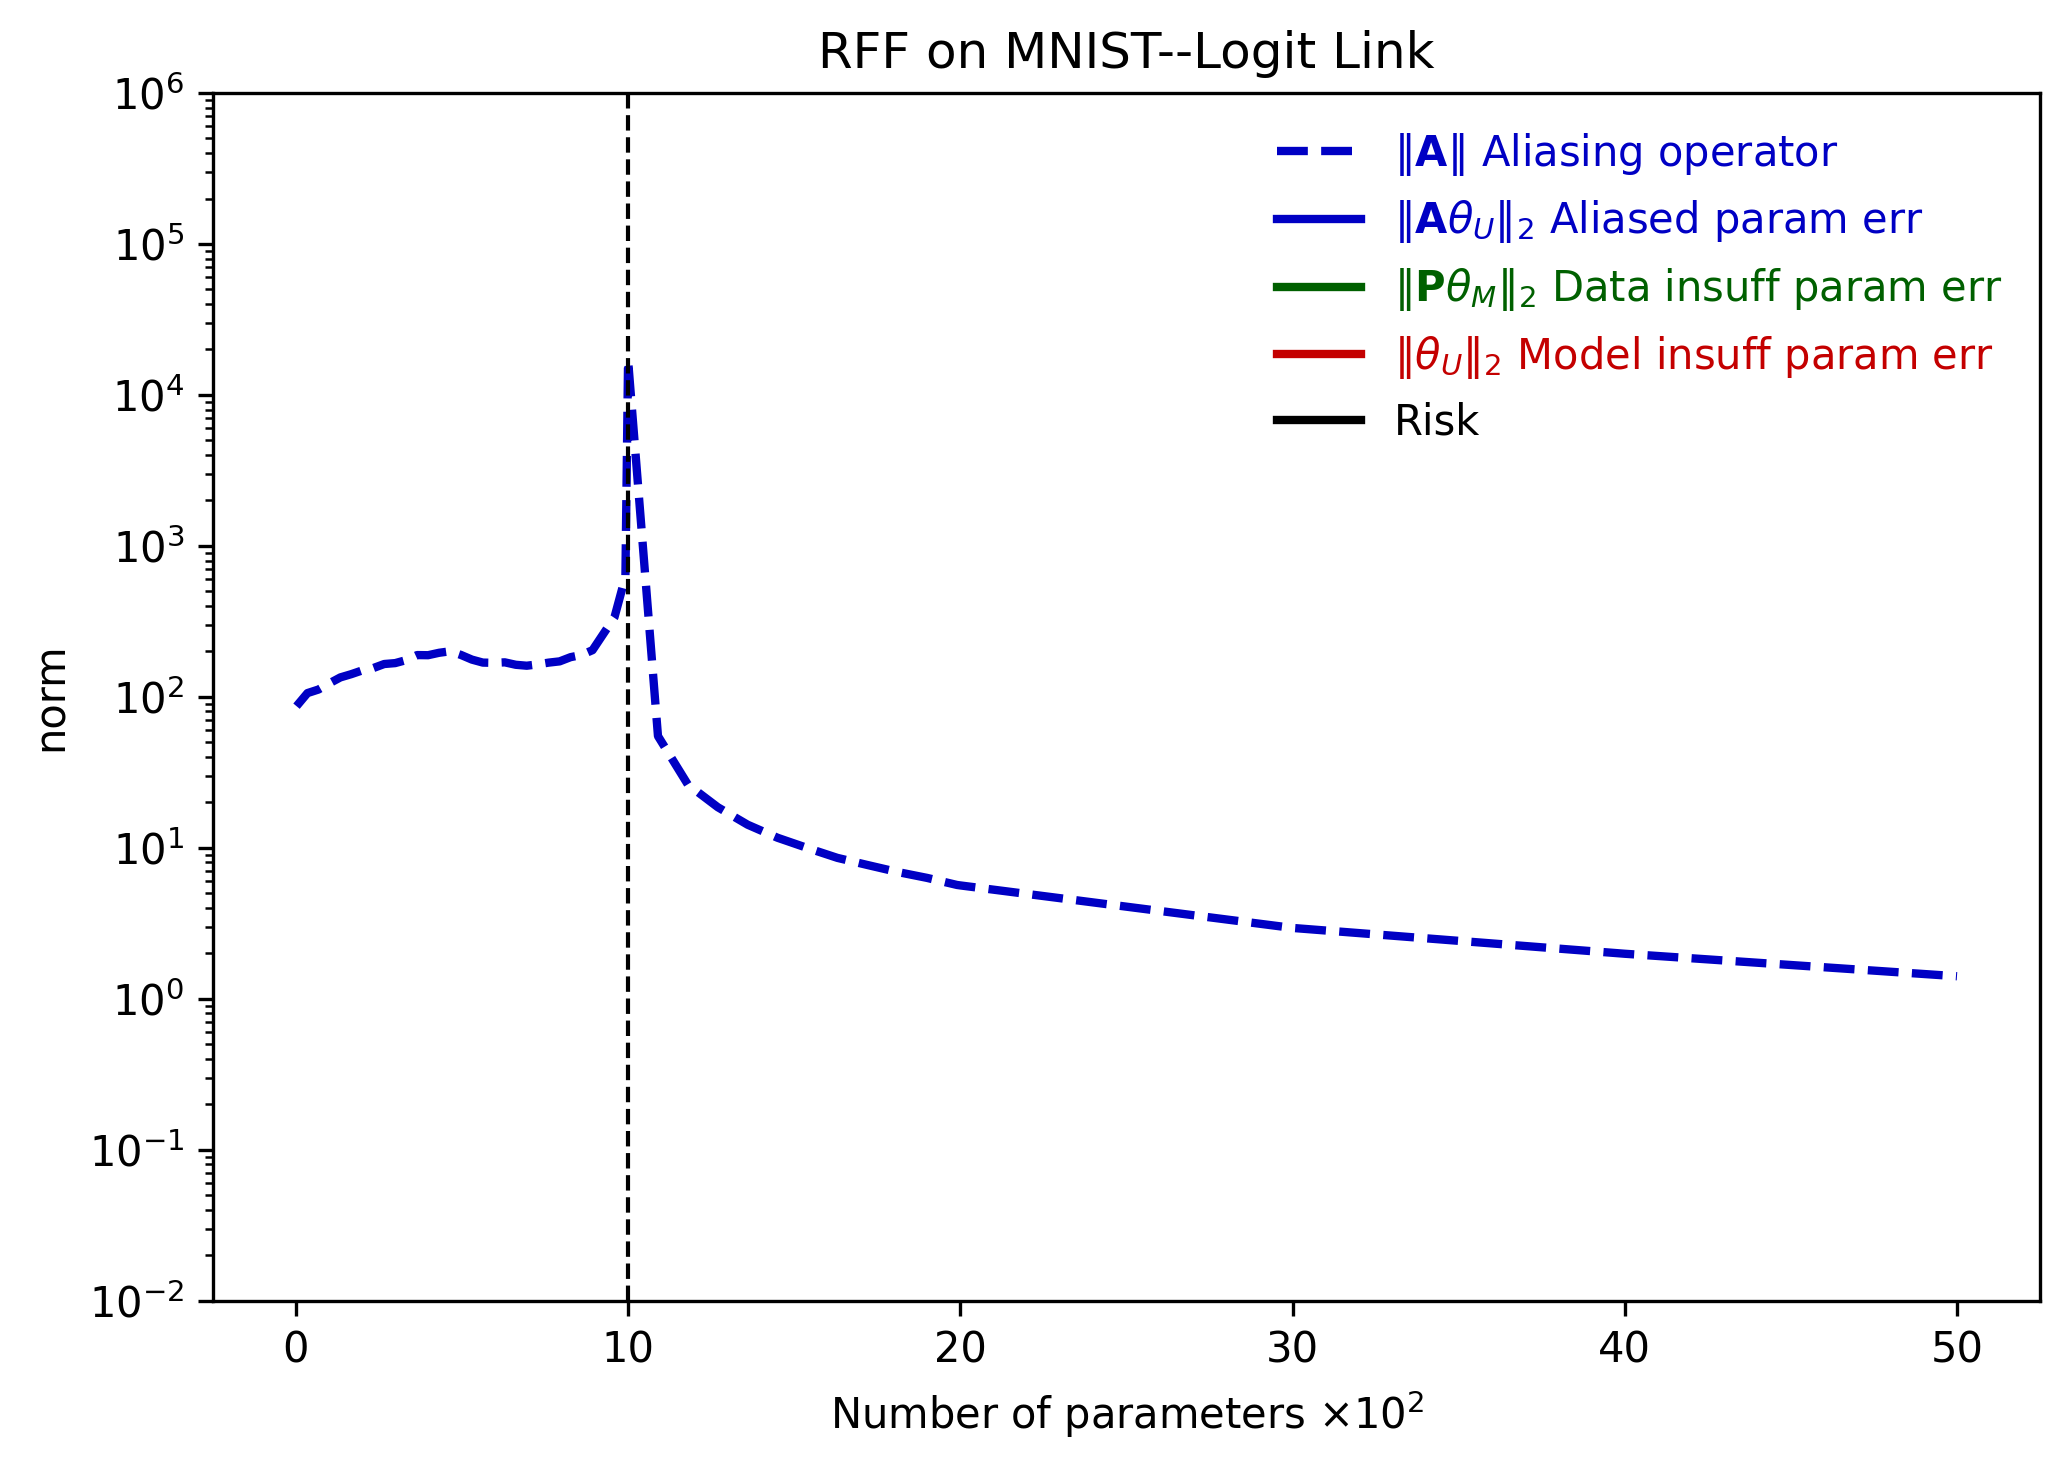

In [22]:
# Plot RFF MNIST

## load the results
data = np.load('rff_mnist_GAD_logit_link.npz')
t = data['t']
D = data['D']
ms = data['ms']
norms = data['norms']

## Plot     
plot_results(ms, t, D, norms, title="RFF on MNIST--Logit Link",y_max=1e6,y_min=1e-2, figsize=(7,5))

### CIFAR with RFF and RRF

In [7]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
X =cifar_trainset.data
## Convert to grayscale
X = 0.299 * X[:,:,:,0] + 0.587 * X[:,:,:,1] + 0.114 * X[:,:,:,2]
X = X.reshape(-1, 32*32)/255
Y = np.array(cifar_trainset.targets)

# one-vs-rest for class 0, with a blanced number of points for each class
index_0 = np.argwhere(Y==0)
index_not0 = np.argwhere(Y!=0)[:len(index_0)] # random sample of same number of  points not 0
all_indices = np.sort(np.concatenate([index_0, index_not0]))

X = X[all_indices].reshape(-1, 32*32)
Y = Y[all_indices].reshape(-1)

N = X.shape[0]
D = N

# one-vs rest for class 0
Y = (Y==0).astype(float)

In [8]:
# Compute everything for CIFAR 
## RRF 
## Y = one-vs-rest for image 0

t = 10**3 # number of training points (Belkin uses 10**4)

M = universe(X, activation=relu)
theta, Y = parameter_setup(M, Y, t)

D = min(t * 7 + 1, M.shape[1]) 
ms, norms = all_norms(M[:,:D], Y, theta[:D], t, ms=None)

np.savez('rrf_cifar_GAD', t=t, D=D, ms=ms, norms=norms)

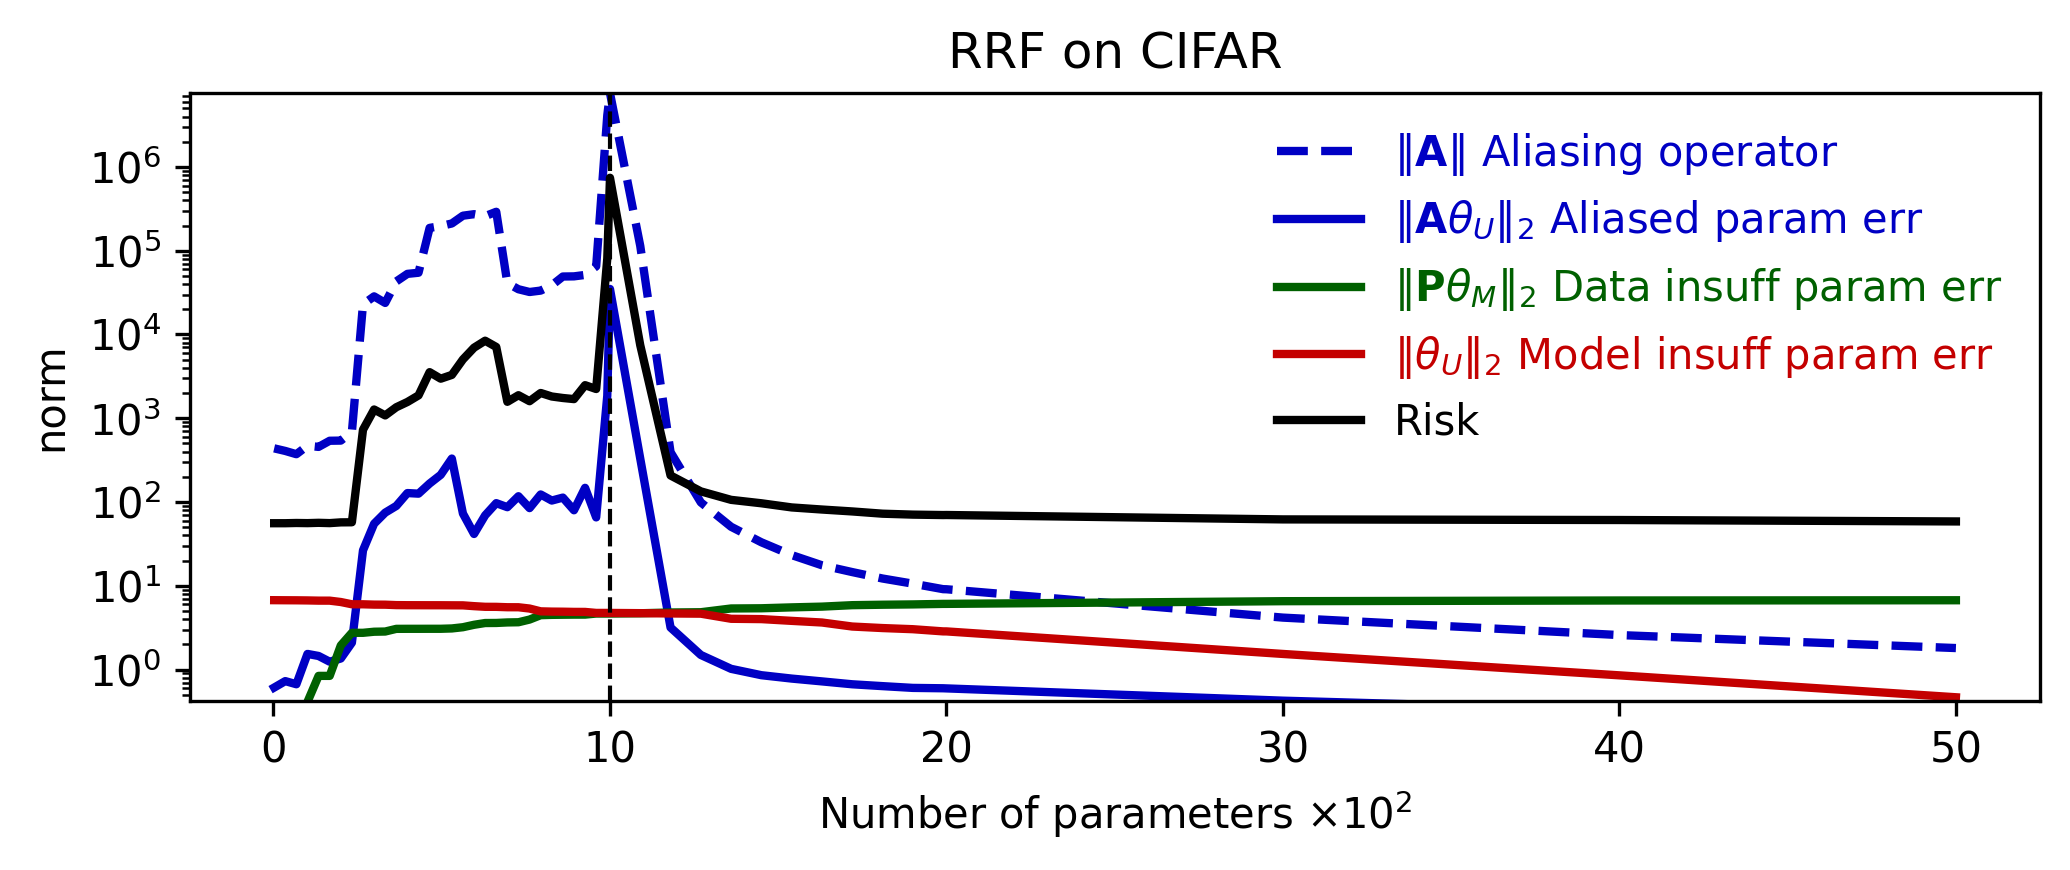

In [9]:
# load the results
data = np.load('rrf_cifar_GAD.npz')
t = data['t']
D = data['D']
ms = data['ms']
     
plot_results(ms, t, D, norms, title="RRF on CIFAR")

#### CIFAR RRF logit link


In [10]:
Y = np.array(cifar_trainset.targets)
Y = Y[all_indices].reshape(-1)

N = X.shape[0]
D = N

# one-vs rest for class 0
Y = (Y==0).astype(float)


epsilon = 0.0001
# 1 -> 1-ε,  and 0 -> ε

Z = (Y * (1 - 2* epsilon)) + epsilon # scale to (epsilon, 1-epsilon) to avoid log(0) and log(1) issues
Z = np.log(Z/(1-Z))                  # logit link function



In [11]:

# This takes a little time, since the regularization means solving with a tweaked universe matrix that is much larger.
theta, Z = parameter_setup(M, Z, t,regularization=1e-5)

In [12]:
ms, norms = all_norms(M[:,:D], Z, theta[:D], t, ms=None)
np.savez('rrf_cifar_GAD_logit_link', t=t, D=D, ms=ms, norms=norms)

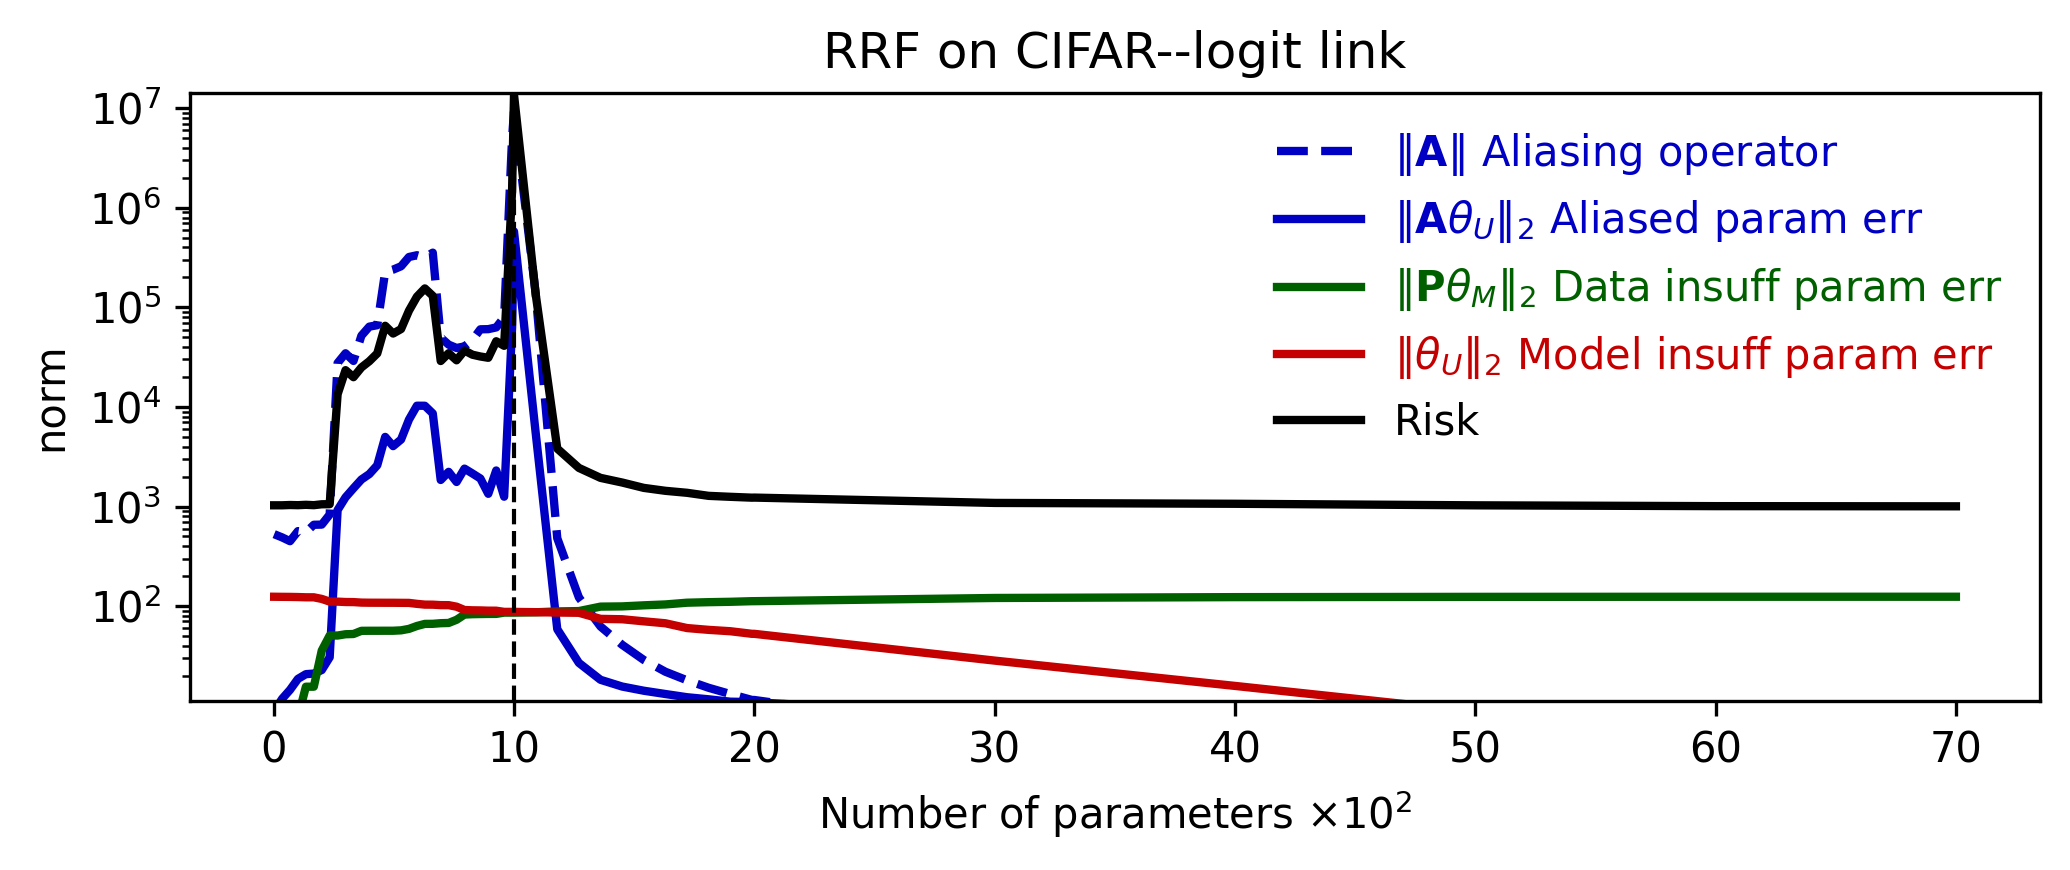

In [13]:
# load the results
data = np.load('rrf_cifar_GAD_logit_link.npz')
t = data['t']
D = data['D']
ms = data['ms']
norms = data['norms']

plot_results(ms, t, D, norms, title="RRF on CIFAR--logit link")

#### CIFAR RFF One-vs-Rest

In [14]:
# Compute everything for CIFAR RFF 
## Y = one-vs-rest for image 0


M = universe(X, activation=ff, scale_factor=0.2)
theta, Y = parameter_setup(M, Y, t) # takes a little time, thanks to the regularization.

D = M.shape[1] 
ms, norms = all_norms(M[:,:D], Y, theta[:D], t, ms=None)

np.savez('rff_cifar_GAD', t=t, D=D, ms=ms, norms=norms)

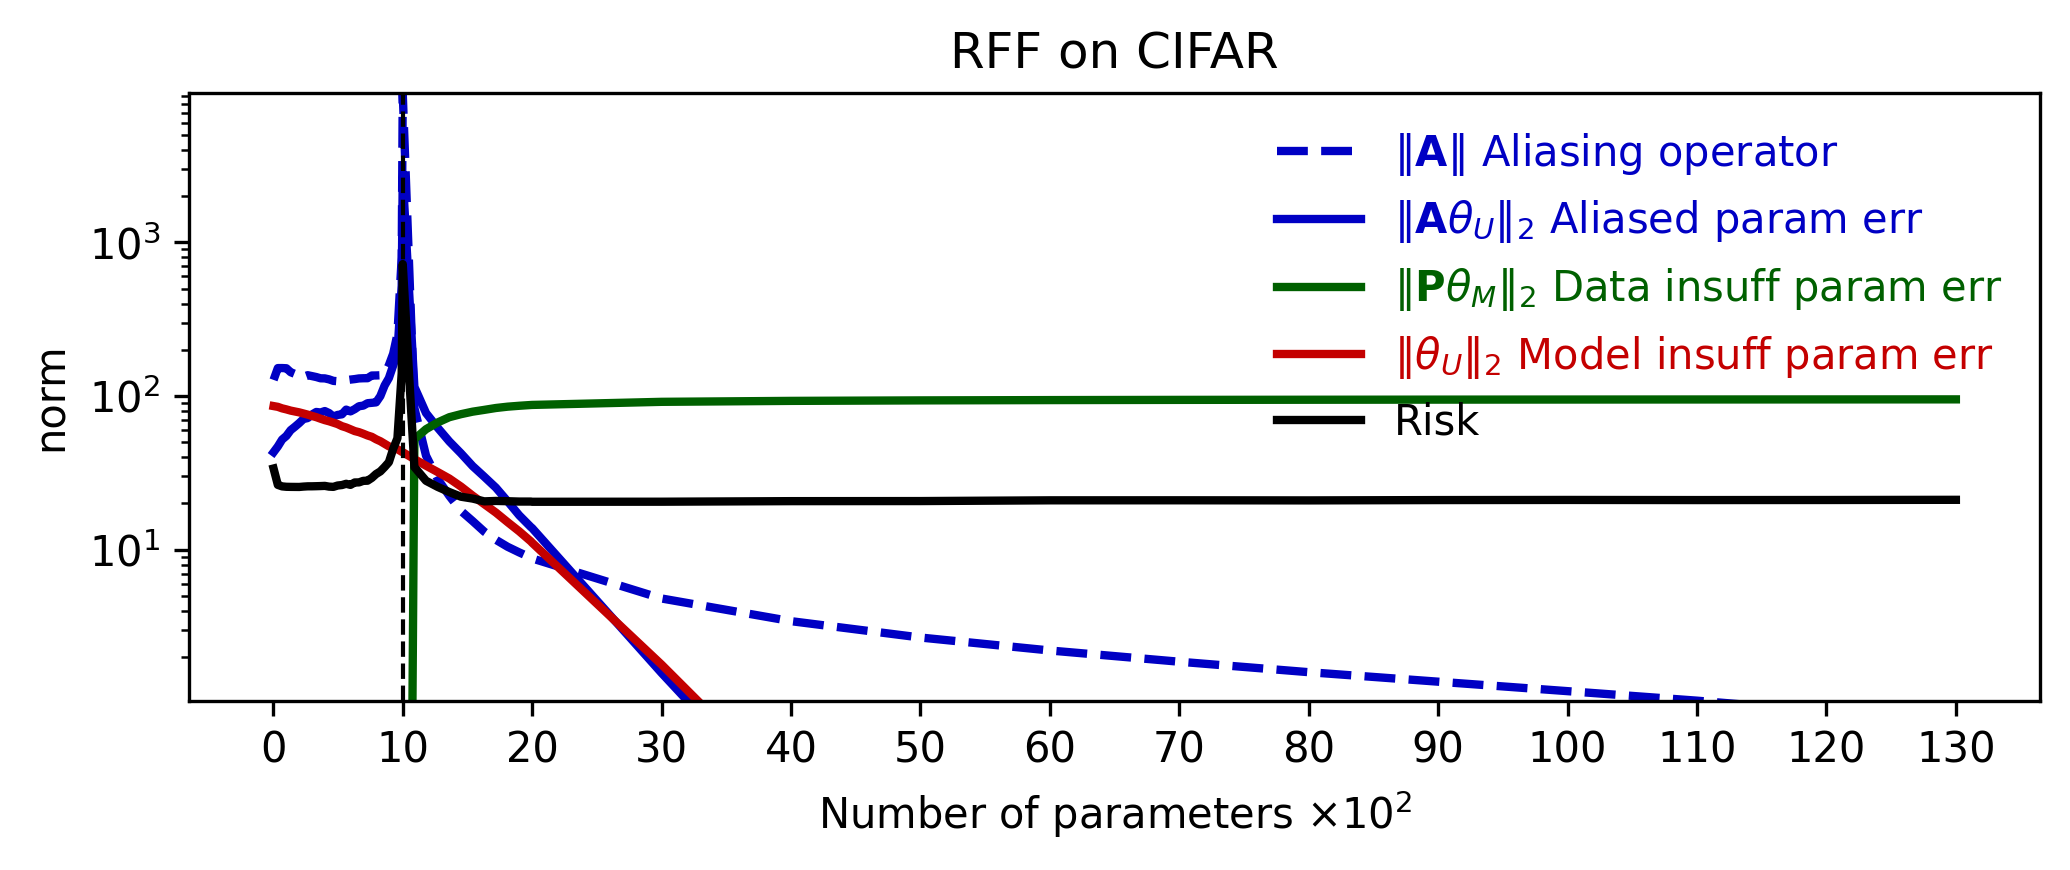

In [15]:
# load the results
data = np.load('rff_cifar_GAD.npz')
t = data['t']
D = data['D']
ms = data['ms']
norms = data['norms']

plot_results(ms, t, D, norms, title="RFF on CIFAR")

#### CIFAR RFF Logit link


In [16]:
Y = np.array(cifar_trainset.targets)
Y = Y[all_indices].reshape(-1)

N = X.shape[0]
D = N

# one-vs rest for class 0
Y = (Y==0).astype(float)


epsilon = 0.0001
# 1 -> 1-ε,  and 0 -> ε

Z = (Y * (1 - 2* epsilon)) + epsilon # scale to (epsilon, 1-epsilon) to avoid log(0) and log(1) issues
Z = np.log(Z/(1-Z))                  # logit link function


In [17]:

# This takes a little time, since the regularization means solving with a tweaked universe matrix that is much larger.
theta, Z = parameter_setup(M, Z, t,regularization=1e-5)

In [18]:
ms, norms = all_norms(M[:,:D], Z, theta[:D], t, ms=None)
np.savez('rff_cifar_GAD_logit_link', t=t, D=D, ms=ms, norms=norms)

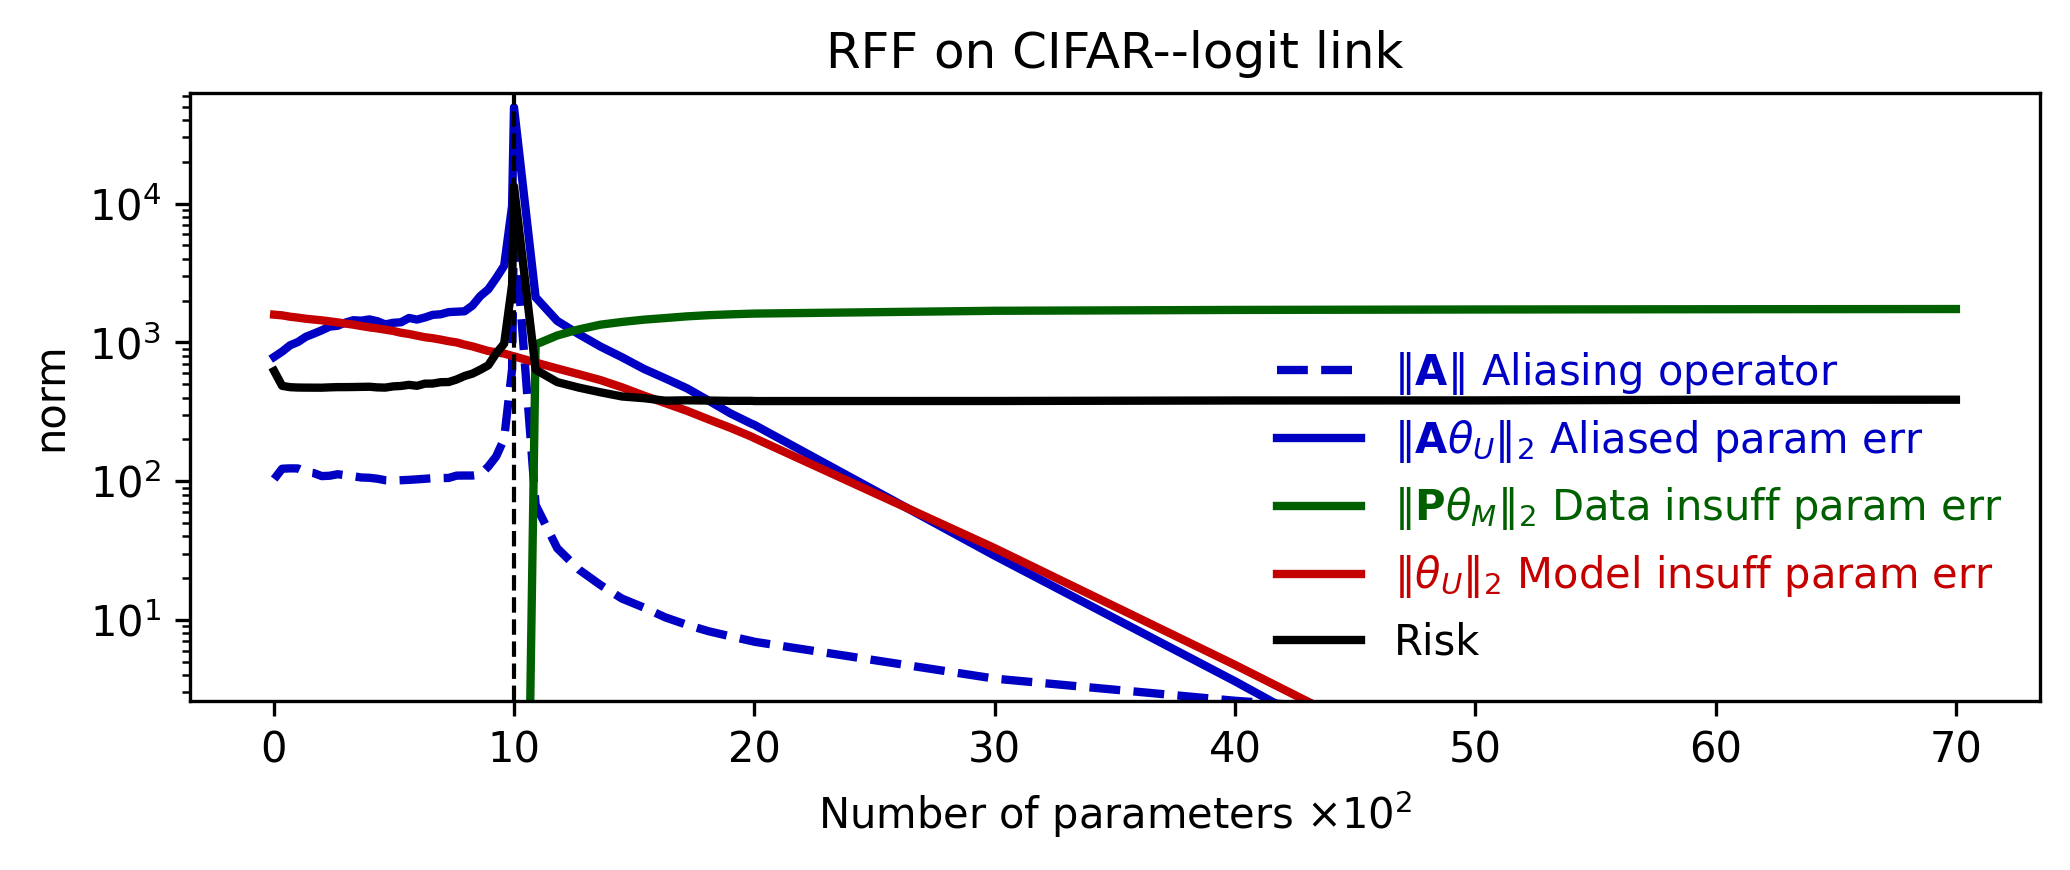

In [19]:
# load the results
data = np.load('rff_cifar_GAD_logit_link.npz')
t = data['t']
D = data['D']
ms = data['ms']
norms = data['norms']

plot_results(ms, t, D, norms, title="RFF on CIFAR--logit link")

## Mei-Montanari Sphere

Learn on the sphere $\mathbb{S}^{\delta-1}(\sqrt{\delta})$, with random features coming from the same sphere.  Labels are drawn from the standard normal.


In [8]:
δ = 1024  # dim of the input data  (MM has this grow with t or m)
# Note that δ=1024 for CIFAR10

t = 10**3 # number of training points 
N = 10**4 # number of total points


X = rng.standard_normal((N, δ))  # random data
X = np.sqrt(δ) * (X/norm(X, axis=1).reshape(-1,1)) # normalize to MM sqrt(δ) sphere

Y = rng.standard_normal(len(X)) # standard normal labels


#### RFF on MM 

In [21]:
M = universe(X, activation=ff, scale_factor=δ)
theta, Y = parameter_setup(M, Y, t)

D = min(t * 7 + 1, M.shape[1]) 
ms, norms = all_norms(M[:,:D], Y, theta[:D], t, ms=None)

np.savez('rff_MM_GAD', t=t,D=D, ms=ms, norms=norms)

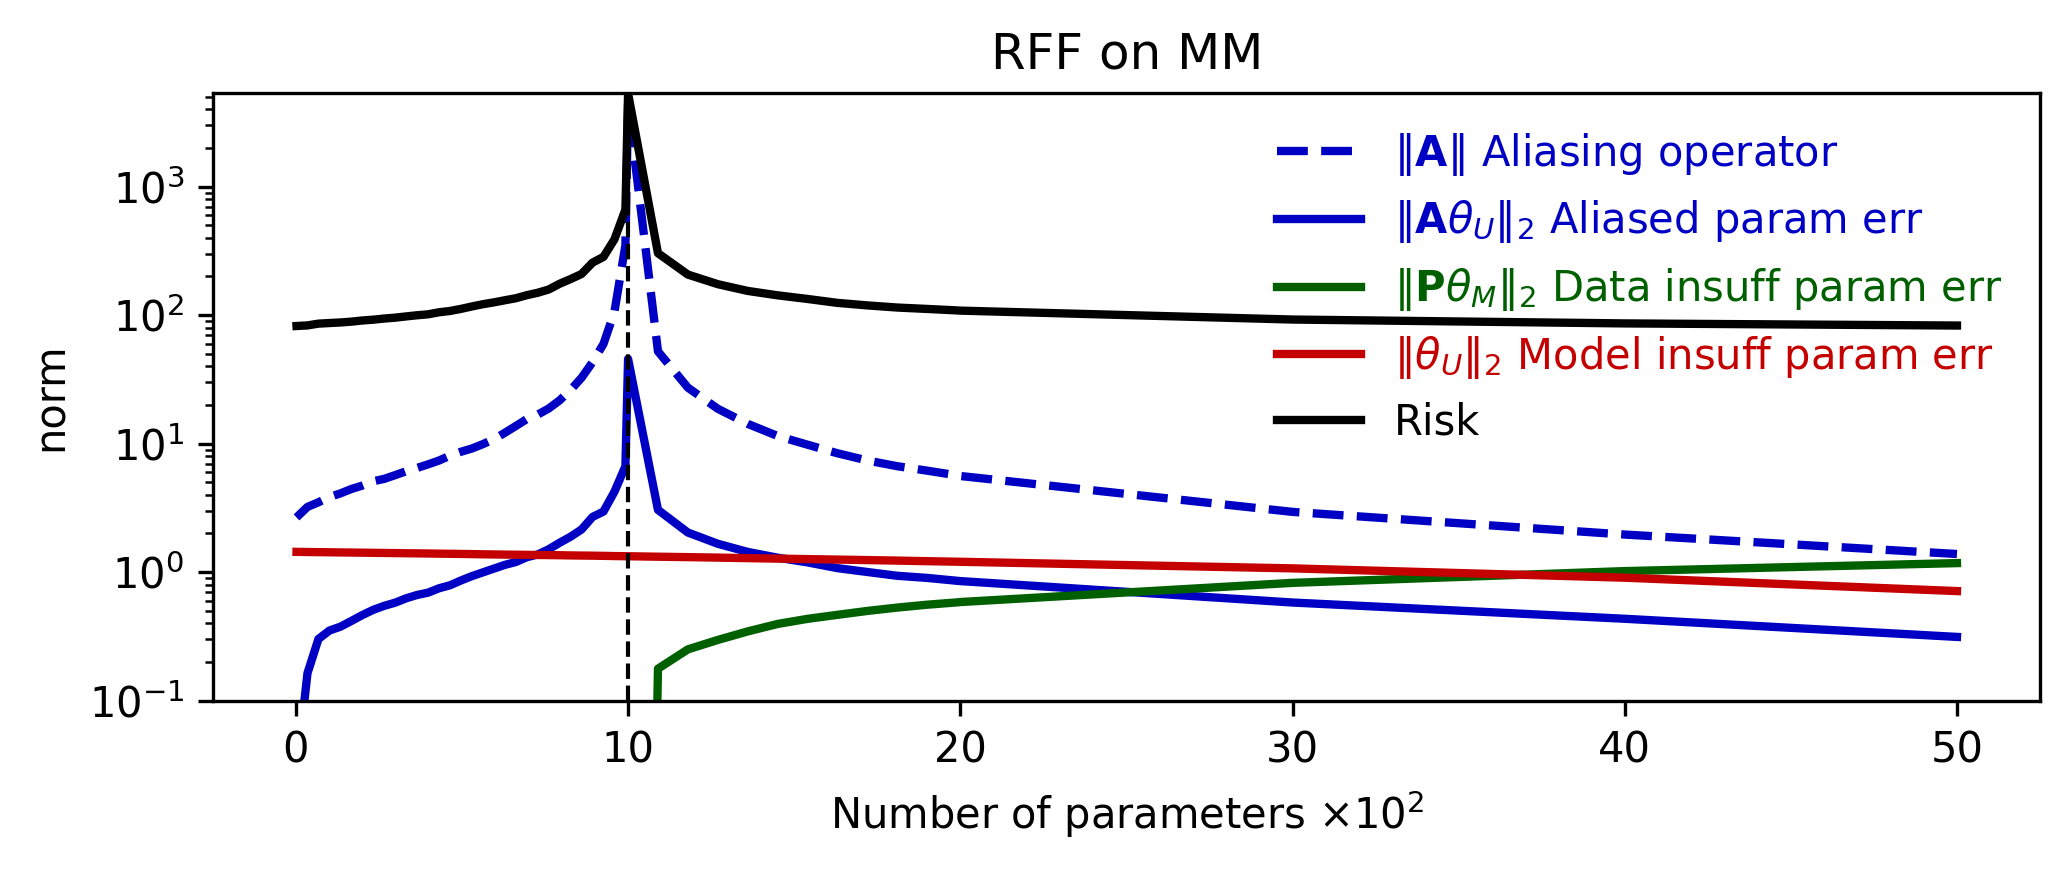

In [22]:
# load the results
data = np.load('rff_MM_GAD.npz')
t = data['t']
D = data['D']
ms = data['ms']
results = data['norms']

plot_results(ms, t, D, results, title="RFF on MM",y_min=1e-1)

#### RRF on MM 

In [9]:
M = universe(X, activation=relu, scale_factor=δ)
theta, Y = parameter_setup(M, Y, t)

D = min(t * 7 + 1, M.shape[1]) 
ms, norms = all_norms(M[:,:D], Y, theta[:D], t, ms=None)

np.savez('rrf_MM_GAD', t=t, D=D, ms=ms, norms=norms)

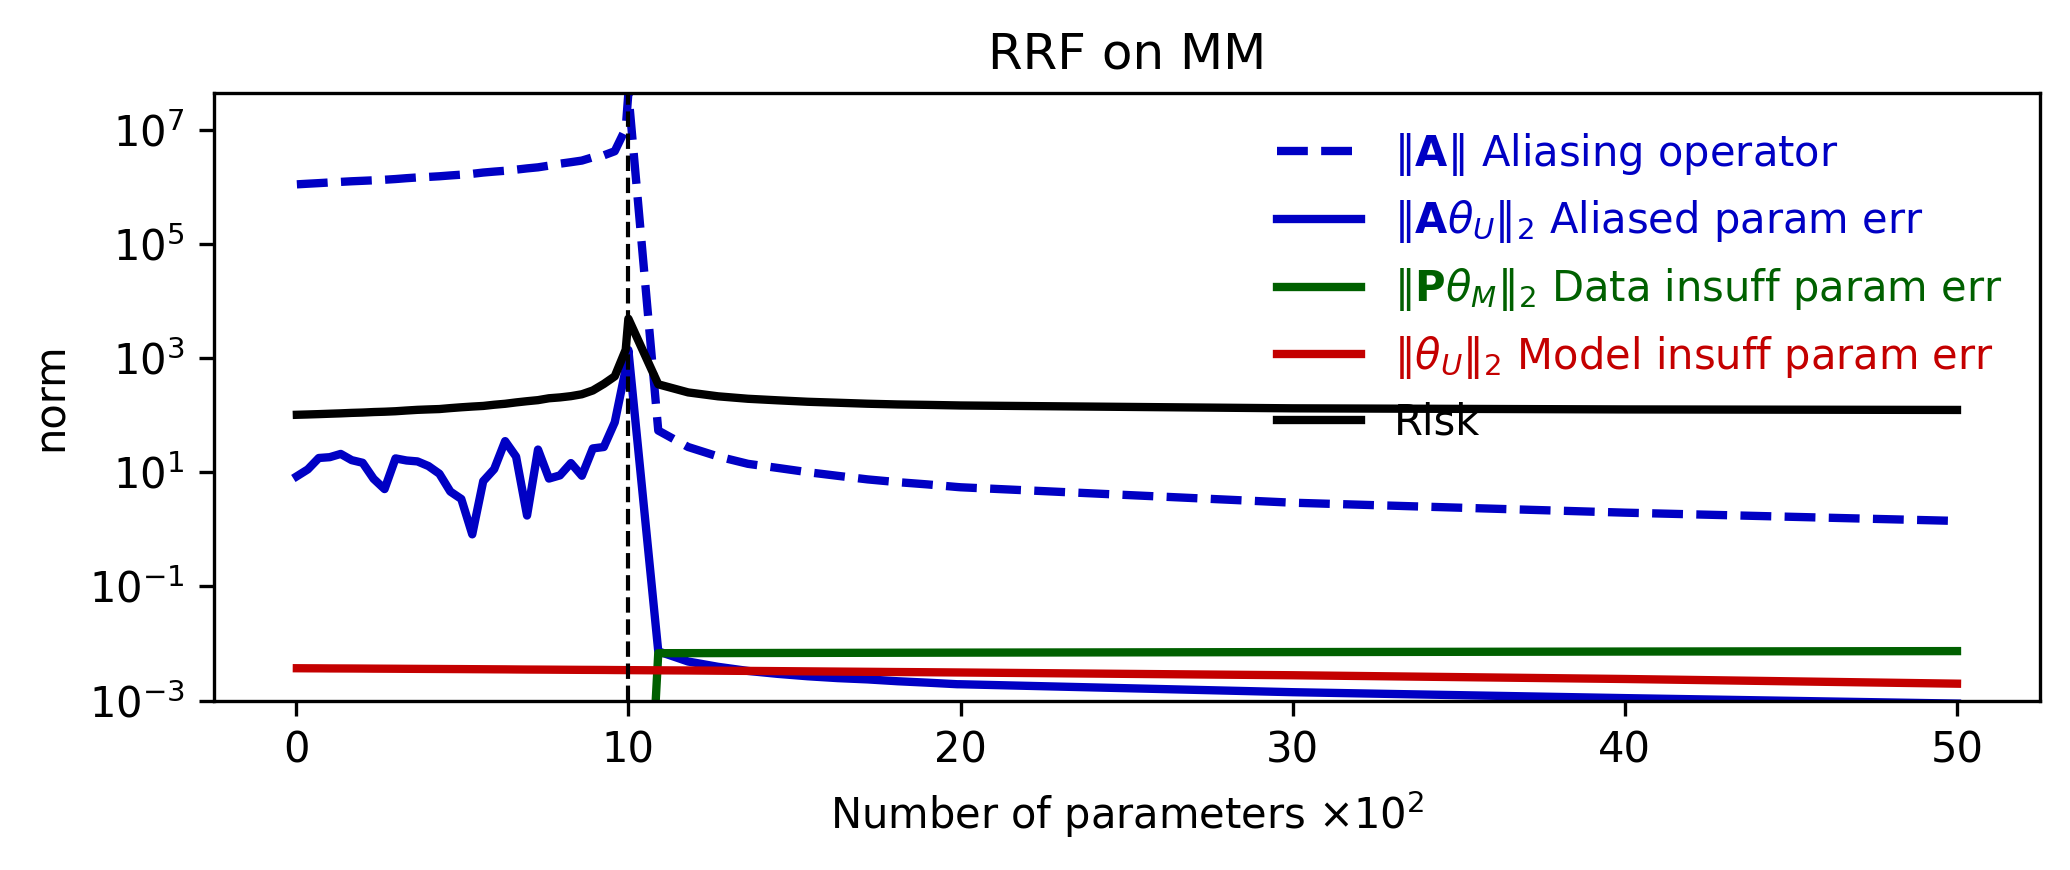

In [10]:
# load the results
data = np.load('rrf_MM_GAD.npz')
t = data['t']
D = data['D']
ms = data['ms']
results = data['norms']

for i in [1,2,3]:
    results[i] = results[i]*10

plot_results(ms, t, D, results, title="RRF on MM",y_min=1e-3)

In [11]:
## Plot all six (not the logit-links) together
# Code to plot the results
def plot_all_results(title=None, y_min=None, y_max=None, figsize=(12,6)):
    """Plot the results of the norms computed by all_norms
    
    Parameters
    ----------
    ms : numpy array
        Model sizes
    t : int
        Number of training points.  
    D : int 
        Total number of basis functions in the Universe matrix
    results : list    
        List of norms should contain, in order,
        A_norm, A_theta_norm, P_theta_norm, IU_theta_norm, label_risk
        each of which should have a shape of len(ms)
    title : str, optional
        Title of the plot, by default None
    y_min : float, optional  
        Minimum log_10 value of the y-axis.  Will default to min of
        the data (except for data insuff P_theta, which has min = 0)
    y_max : float, optional  
        Maximum log_10 value of the y-axis.  Will default to max of
        the data.
 
    """

    red = (196/255, 0, 0)
    green = (0, 96/255, 0)
    blue = (0, 0, 196/255)
    colors = [blue, blue, green, red, 'k']
    line_types = ['--', '-', '-', '-', '-']
    labels = [r'$\|\mathbf{A}\|$', 
            r'$\|\mathbf{A}\theta_U\|$', 
            r'$\|\mathbf{P}\theta_M\|$', 
            r'$\|\theta_U\|$',
            'Risk']

    data_sets = ['mnist', 'cifar', 'MM']
    models = ['rrf', 'rff']

    # The actual parameters θ can be scaled arbitrarily, by scaling M in the opposite way. 
    # (Operator norm and risk are invariant under this scaling)
    # Here set scalings that make these lines land in a reasonable place on the plot
    scalings = {('mnist','rrf'): 10, 
                ('mnist','rff'): 1e-1,
                ('cifar','rrf'): 1,
                ('cifar','rff'): 1e-1,
                ('MM','rrf'): 1e4,
                ('MM','rff'): 1}
    fig, axes = plt.subplots(nrows=2,ncols=3, figsize=figsize, sharex=True, sharey="row")
    for i,model in enumerate(models):
        for j,data in enumerate(data_sets):
            with np.load(model+'_'+data+'_GAD.npz') as stored_data:
                ax = axes[i,j]
                if i==0:
                    ax.set_title(f"{data.upper()}")
                t = stored_data['t']
                D = stored_data['D']
                ms = stored_data['ms']
                results = stored_data['norms']
                for k in range(1,4):
                    results[k] = results[k] * scalings[(data,model)]



                 ## actually plot the results
                for k, result in enumerate(results):
                        ax.semilogy(ms, result, 
                                line_types[k], color=colors[k], 
                                lw=2, label=labels[k]) 
                
                

                if i == 0 and j == 0:
                    # Make legend
                    ax.legend(labelcolor='linecolor', frameon=True, framealpha=1)
                    # fix y_max
                if i==0:
                    y_min = 1e-1
                    y_max = 5 * 1e7
                                
                if i==1:
                    y_min=1e-1
                    y_max=1e4

                # setup the x axis
                xs = range(0, 5001, t)
                plt.xticks(xs,[str(x//(t//10)) for x in xs])
                ax.set_xlim(0, 5001)

                # setup the y axis, but omit P_theta because its log is -inf at the beginning
                all_values = np.concatenate([results[ell] for ell in [0,1,3,4]])
                all_values = all_values[~np.isnan(all_values)]

                # if y_min is None:
                #     y_min = np.min(all_values)
                # if y_max is None:
                #     y_max = np.max(all_values)

                ax.vlines(t,y_min,y_max,color='k',linewidth=1, linestyle='dashed')
                ax.set_ylim(y_min, y_max)

                # Label the x-axis
                if i==1 and j==1:
                    if t == 10**4:
                        ax.set_xlabel(r'Number of parameters $\times 10^3$')
                    elif t == 10**3:
                        ax.set_xlabel(r'Number of parameters $\times 10^2$')
                    else:
                        ax.set_xlabel(r'Number of parameters $\times$' + str(t//10))
   
                # Label the y-axis
                if j==0:
                    ax.set_ylabel(model.upper())

                # Hide the right and top spines
                ax.spines[['right', 'top']].set_visible(False)             

                if title is not None:
                    plt.title(title)
    plt.tight_layout()
    plt.savefig('all_GAD.pdf', dpi=300, bbox_inches='tight')

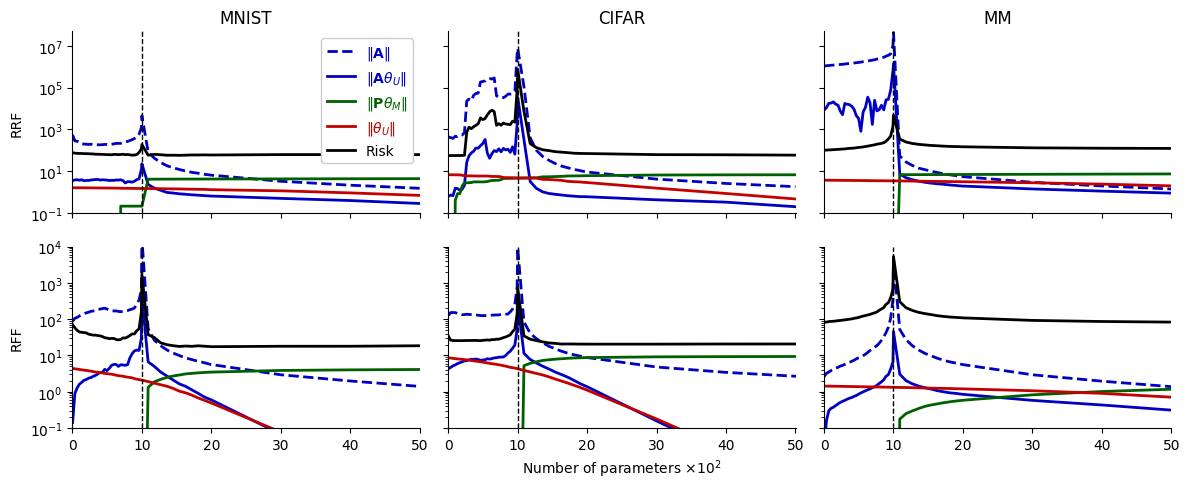

In [12]:
plot_all_results(figsize=(12,5))

# Plot ClusterEx and Collocation data

In [ ]:
data = np.load('rrf_MM_GAD.npz')
t = data['t']
D = data['D']
ms = data['ms']
results = data['norms']

df = pd.DataFrame(results.T, index=ms, columns=['A_norm', 'A_theta_norm', 'P_theta_norm', 'IU_theta_norm', 'label_risk'])
df.to_csv('rrf_MM_GAD.csv')



#plot_results(ms, t, D, results, title="RRF on MM",y_min=1e-3)

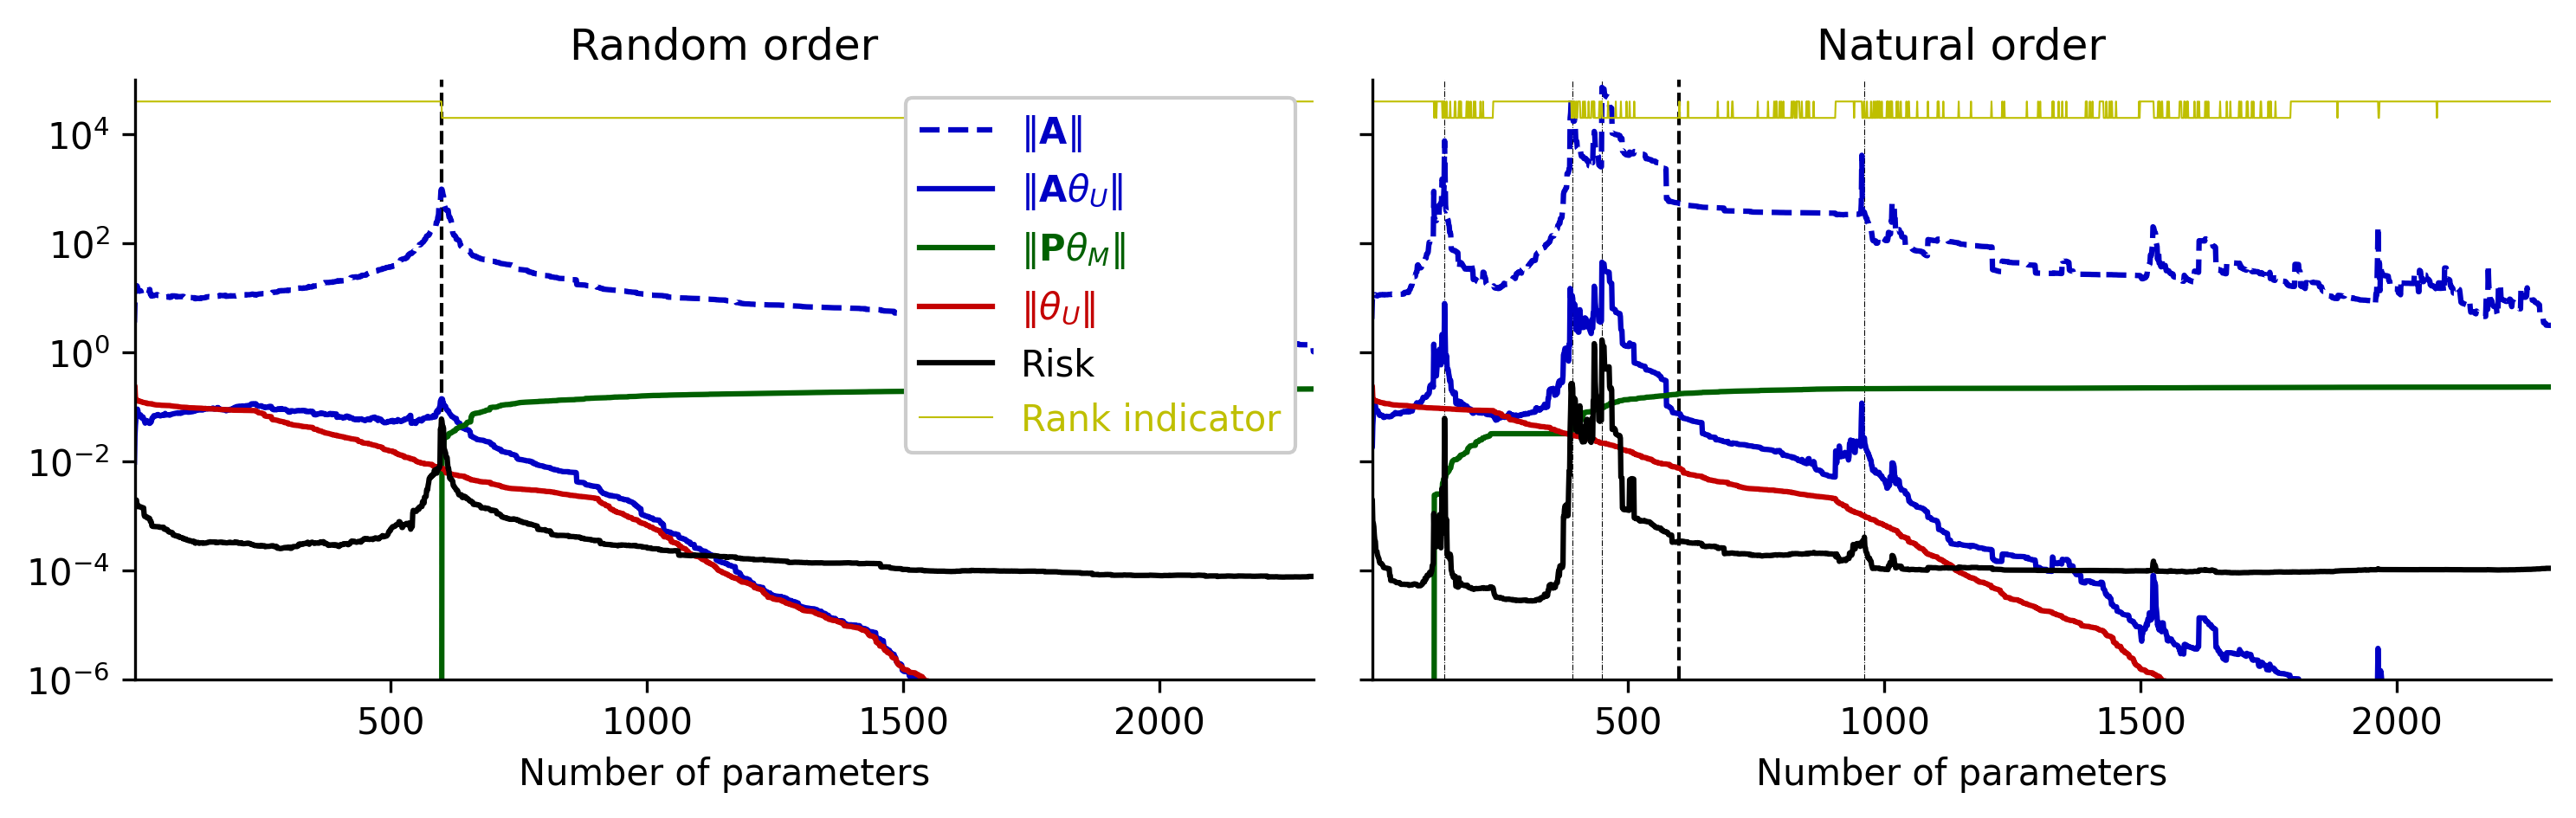

In [ ]:
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

red = (196/255, 0, 0)
green = (0, 96/255, 0)
blue = (0, 0, 196/255)

fig,axes = plt.subplots(nrows=1,ncols=2,sharey=True, figsize=(12,3),dpi=300)

files = ['GusCEdata-random-order.csv','GusCEdata-physicist-order.csv']
titles = ['Random order', "Natural order"]

for i,ax in enumerate(axes):
    df = pd.read_csv(files[i])
    df.columns=['Anorm', 'AthetaU', 'PthetaM', 'thetaU', 'risk', 'deltar']
    ax.semilogy(df.index, df['Anorm'], label=r'$\|\mathbf{A}\|$', color=blue,linestyle='--')
    ax.semilogy(df.index, df['AthetaU'], label=r'$\|\mathbf{A}\theta_U\|$', color=blue)
    ax.semilogy(df.index, df['PthetaM'], label=r'$\|\mathbf{P}\theta_M\|$', color=green)
    ax.semilogy(df.index, df['thetaU'], label=r'$\|\theta_U\|$', color=red)
    ax.semilogy(df.index, df['risk'], label='Risk', color='k')
    ax.semilogy(df.index, df['deltar']/10, label='Rank indicator', color='y', lw=0.5)
 

    ax.set_xlim(1,2300)
    ax.set_xlabel('Number of parameters')

    ax.set_title(titles[i])

    if i==0:
        ax.legend(labelcolor='linecolor', framealpha=1, loc='upper right')   
    
    ax.set_ylim(1e-6,1e5)

    # interpolation threshold
    ax.vlines(600, ax.get_ylim()[0], ax.get_ylim()[1], color='k',lw=1, linestyles='dashed',zorder=0)
 
    # minor lines to see how peaks align
    if i==1:
        peaks = np.argmax(df['risk']), np.argmax(df['risk'][:400]), np.argmax(df['risk'][:300]), 699+np.argmax(df['risk'][700:])
        ax.vlines(np.array(peaks), ax.get_ylim()[0], ax.get_ylim()[1], color='k',lw=0.25, linestyles='dashdot', zorder=0)

plt.subplots_adjust(wspace=0.05)
#plt.tight_layout()
plt.savefig('CEdata.pdf', dpi=300, bbox_inches='tight')


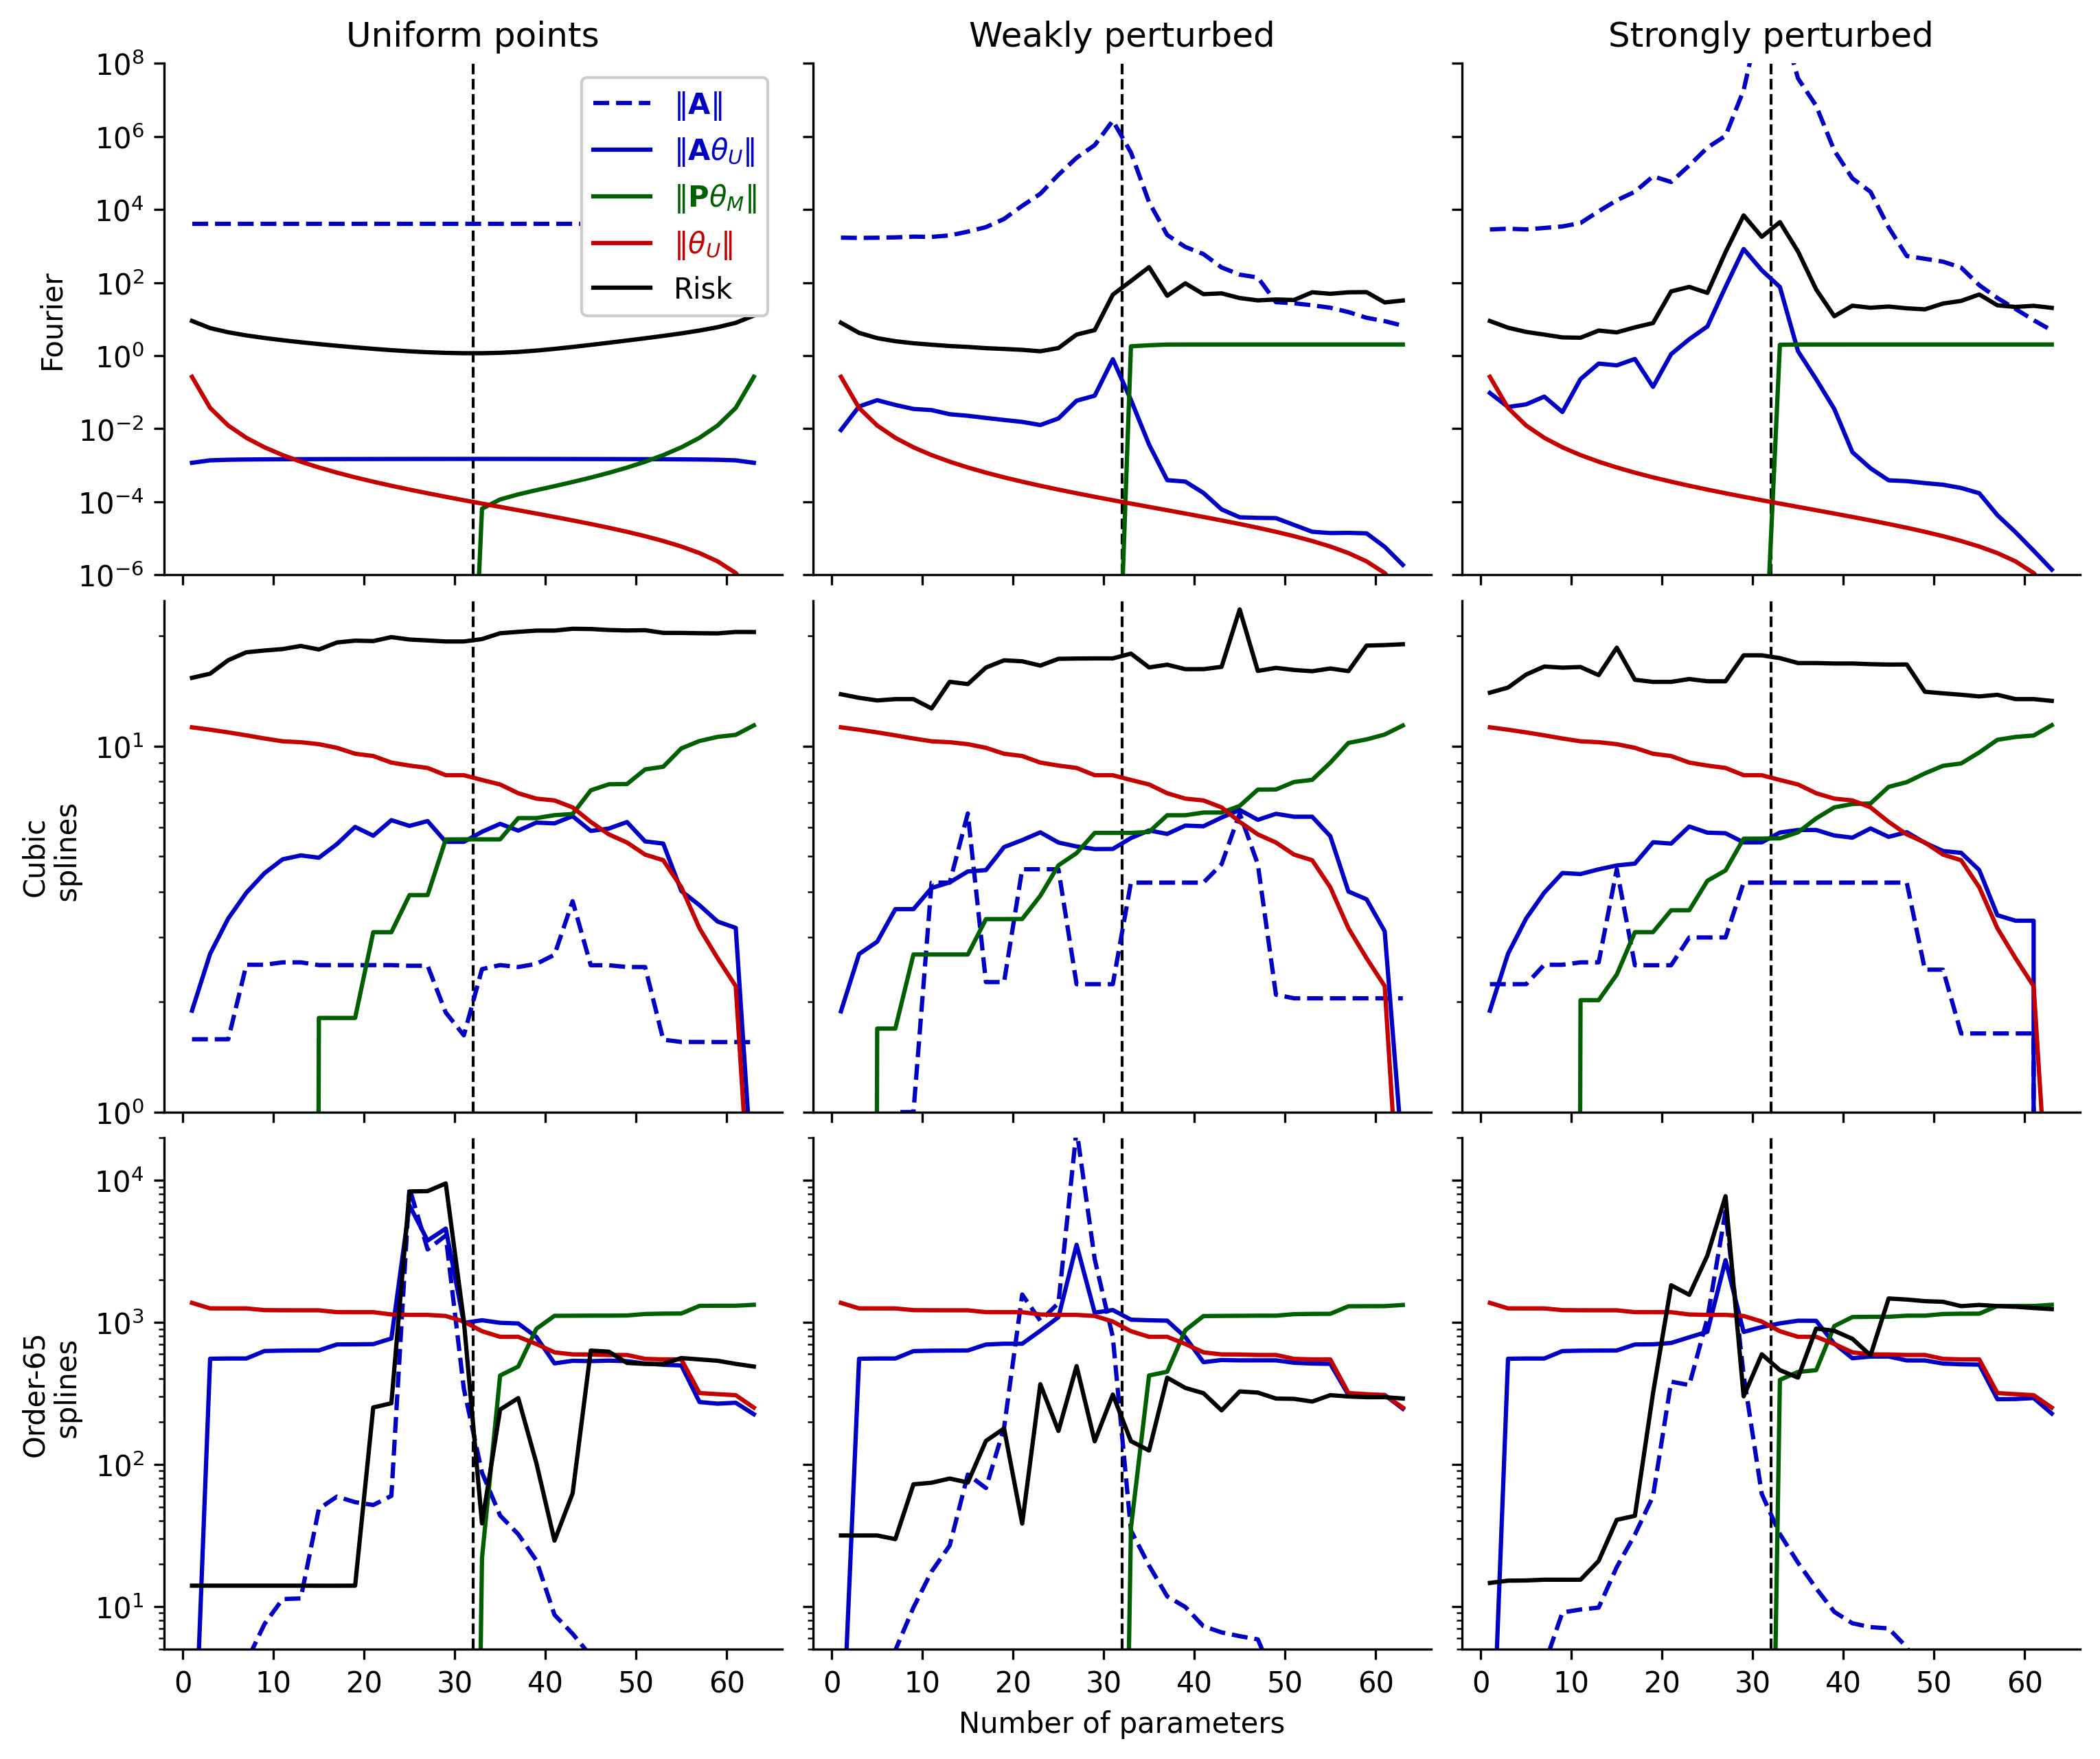

In [ ]:
# Collocation data plot
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

red = (196/255, 0, 0)
green = (0, 96/255, 0)
blue = (0, 0, 196/255)

fig,axes = plt.subplots(nrows = 3,ncols = 3,
                        sharex = True, 
                        sharey = 'row',
                        figsize = (12,10),
                        dpi = 300)

files = ["Collocation/Fourier_000_2349857.csv",
         "Collocation/Fourier_010_2349857.csv",
         "Collocation/Fourier_100_2349857.csv",
         "Collocation/BSplines3_000_2349857.csv",
         "Collocation/BSplines3_010_2349857.csv",
         "Collocation/BSplines3_100_2349857.csv",
         "Collocation/BSplines66_000_2349857.csv",
         "Collocation/BSplines66_010_2349857.csv",
         "Collocation/BSplines66_100_2349857.csv"]

rows = ['Fourier', 'Cubic\n splines', 'Order-65\n splines']
titles = ['Uniform points', 'Weakly perturbed', 'Strongly perturbed',]

for i,ax in enumerate(axes.flatten()):
    df = pd.read_csv(files[i], header=None, index_col=0)
    df.columns=['Anorm', 'AthetaU', 'PthetaM', 'thetaU', 'risk']
    ax.semilogy(df.index, df['Anorm'], label=r'$\|\mathbf{A}\|$', color=blue,linestyle='--')
    ax.semilogy(df.index, df['AthetaU'], label=r'$\|\mathbf{A}\theta_U\|$', color=blue)
    ax.semilogy(df.index, df['PthetaM'], label=r'$\|\mathbf{P}\theta_M\|$', color=green)
    ax.semilogy(df.index, df['thetaU'], label=r'$\|\theta_U\|$', color=red)
    ax.semilogy(df.index, df['risk'], label='Risk', color='k')
 
    y_max = {0:1e8, 1:2.5*1e1, 2:2*1e4}
    y_min = {0:1e-6, 1:1, 2:5}
    
    ax.set_ylim(y_min[i//3],y_max[i//3])

    if i == 7:
        ax.set_xlabel('Number of parameters')

    if i < 3:
        ax.set_title(titles[i])

    if i % 3 == 0:
        ax.set_ylabel(rows[i//3])

    if i==0:
        ax.legend(labelcolor='linecolor', framealpha=1, loc='upper right')   
    
    #ax.set_ylim(1e-6,1e5)

    # interpolation threshold
    ax.vlines(32, ax.get_ylim()[0], ax.get_ylim()[1], color='k',lw=1, linestyles='dashed',zorder=0)
 
 
plt.subplots_adjust(wspace=0.05, hspace=0.05)
#plt.tight_layout()
plt.savefig('Collocation.pdf', dpi=300, bbox_inches='tight')

